State Farm Distracted Drivers
=============

Prev Exercises: Udacity:DeepLearning:TensorFlow:notMNIST  

Fit Logistic Regression SGD with random image rotation (TensorFlow)
------------

In [1]:
import sys
print sys.version

from joblib import Parallel, delayed  
import multiprocessing
nCores = multiprocessing.cpu_count() - 2 # Allow other apps to run
print 'nCores: %d' % (nCores)

from datetime import datetime, time
print 'now: %s' % str(datetime.now())

2.7.11 (default, Jan 28 2016, 14:07:46) 
[GCC 4.2.1 Compatible Apple LLVM 7.0.2 (clang-700.1.81)]
nCores: 14
now: 2016-05-23 08:15:24.694001


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Image
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects.lib import grid
from rpy2.robjects.lib import ggplot2
import rpy2.robjects.pandas2ri

import numpy as np
np.set_printoptions(precision=4, suppress=True)
import os
import pandas as pd
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

import tensorflow as tf
print 'tf.__version__:%s' % str(tf.__version__)

%run img_utils.py

tf.__version__:0.8.0


/usr/local/lib/python2.7/site-packages/rpy2/robjects/lib/ggplot2.py:59: UserWarning: This was designed againt ggplot2 version 2.0.0 but you have 2.1.0
  warnings.warn('This was designed againt ggplot2 version %s but you have %s' % (TARGET_VERSION, ggplot2.__version__))


## Analytics Specs

### This Project

In [3]:
%run img_glbSpec_SFDD_ImgSz_64.py

imported img_glbSpec_SFDD_Img_Sz_64.py


In [4]:
# print '\nglbDataFile: %s' % (glbDataFile)

print '\nglbRspClass: %s' % (glbRspClass)
print 'glbRspClassN: %d' % (glbRspClassN)
print 'glbRspClassDesc: '; print(glbRspClassDesc)

print '\nglbImg:'; print(glbImg)

print '\nglbTfwVarSeed: %d' % (glbTfwVarSeed)

print '\nglbPickleFile: %s' % (glbPickleFile)


glbRspClass: ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
glbRspClassN: 10
glbRspClassDesc: 
{'c9': 'talking to passenger', 'c8': 'hair and makeup', 'c3': 'texting - left', 'c2': 'talking on the phone - right', 'c1': 'texting - right', 'c0': 'normal driving', 'c7': 'reaching behind', 'c6': 'drinking', 'c5': 'operating the radio', 'c4': 'talking on the phone - left'}

glbImg:
{'color': False, 'crop': {'x': (80, 560)}, 'shape': (480, 640, 3), 'pxlDepth': 255.0, 'center_scale': True, 'size': 64}

glbTfwVarSeed: 131

glbPickleFile: {'models': 'data/img_M_SFDD_ImgSz_64.pickle', 'data': 'data/img_D_SFDD_ImgSz_64.pickle'}


## Import Data

### This Project

In [17]:
%run img_utils.py
glbObsFitIdn, glbObsFitFtr, glbObsFitRsp, \
glbObsVldIdn, glbObsVldFtr, glbObsVldRsp, \
glbObsNewIdn, glbObsNewFtr, glbObsNewRsp, \
sbtNewCorDf, \
_ = myimportDbs(glbPickleFile['data'])

glbObsTrnIdn = glbObsFitIdn + glbObsVldIdn
glbObsTrnFtr = np.vstack((glbObsFitFtr, glbObsVldFtr))
glbObsTrnRsp = np.concatenate((glbObsFitRsp, glbObsVldRsp))

print('Fit pickled set:', 
      len(glbObsFitIdn), glbObsFitFtr.shape, glbObsFitRsp.shape)
print('Vld pickled set:', 
      len(glbObsVldIdn), glbObsVldFtr.shape, glbObsVldRsp.shape)
print('Trn pickled set:', 
      len(glbObsTrnIdn), glbObsTrnFtr.shape, glbObsTrnRsp.shape)    
print('New pickled set:', 
      len(glbObsNewIdn), glbObsNewFtr.shape, glbObsNewRsp.shape)

Importing database from data/img_D_SFDD_ImgSz_64.pickle...
('Fit pickled set:', 18077, (18077, 64, 64), (18077,))
('Vld pickled set:', 4347, (4347, 64, 64), (4347,))
('Trn pickled set:', 22424, (22424, 64, 64), (22424,))
('New pickled set:', 79726, (79726, 64, 64), (79726,))


First reload the data we generated in `1_notmist.ipynb`.

In [7]:
# pickle_file = 'data/notMNIST.pickle'

# with open(pickle_file, 'rb') as f:
#   save = pickle.load(f)
#   glbXFit = save['glbXFit']
#   glbYFit = save['glbYFit']
#   glbXVld = save['glbXVld']
#   glbYVld = save['glbYVld']
#   glbXNew = save['glbXNew']
#   glbYNew = save['glbYNew']
#   del save  # hint to help gc free up memory
#   print('Training set', glbXFit.shape, glbYFit.shape)
#   print('Validation set', glbXVld.shape, glbYVld.shape)
#   print('Test set', glbXNew.shape, glbYNew.shape)

Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [18]:
def lclreformatData(I, X, Y):  
  X = X.reshape((-1, glbImg['size'] * glbImg['size'])).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  Y = (np.arange(glbRspClassN) == Y[:,None]).astype(np.float32)
  return I, X, Y

glbITrn, glbXTrn, glbYTrn = lclreformatData(
    glbObsTrnIdn, glbObsTrnFtr, glbObsTrnRsp)
glbIFit, glbXFit, glbYFit = lclreformatData(
    glbObsFitIdn, glbObsFitFtr, glbObsFitRsp)
glbIVld, glbXVld, glbYVld = lclreformatData(
    glbObsVldIdn, glbObsVldFtr, glbObsVldRsp)
glbINew, glbXNew, glbYNew = lclreformatData(
    glbObsNewIdn, glbObsNewFtr, glbObsNewRsp)

print('Trn reshaped set:', len(glbITrn), glbXTrn.shape, glbYTrn.shape)
print('Fit reshaped set:', len(glbIFit), glbXFit.shape, glbYFit.shape)
print('Vld reshaped set:', len(glbIVld), glbXVld.shape, glbYVld.shape)
print('New reshaped set:', len(glbINew), glbXNew.shape, glbYNew.shape)

('Trn reshaped set:', 22424, (22424, 4096), (22424, 10))
('Fit reshaped set:', 18077, (18077, 4096), (18077, 10))
('Vld reshaped set:', 4347, (4347, 4096), (4347, 10))
('New reshaped set:', 79726, (79726, 4096), (79726, 10))


In [19]:
# Check how much incremental memory is used for Fit obs
del glbObsFitIdn, glbObsFitFtr, glbObsFitRsp
del glbIFit, glbXFit, glbYFit

# Check how much incremental memory is used for Trn obs
# del glbObsTrnIdn, glbObsTrnFtr, glbObsTrnRsp
# del glbITrn, glbXTrn, glbYTrn

In [20]:
print glbObsFitFtr.shape
# print glbObsTrnFtr.shape

NameError: name 'glbObsFitFtr' is not defined

## Fit Logistic Regression (TensorFlow)

Let's now switch to stochastic gradient descent training instead, which is much faster. The graph will be similar, except that instead of holding all the training data into a constant node, we create a Placeholder node which will be fed actual data at every call of sesion.run().

imported img_glbSpec_SFDD_Img_Sz_64.py

Logistic Regression (TensorFlow): nObsFit:  100; nObsBtc:   16; rotatePby: 0.2000; rotateMaxAgl:  10; nStepsTfw:   10; lrnRateTfw:0.5000 
  visualize: True; newObs: False; verbose: False


max Pby for cls: c0; desc: normal driving; proba: 0.9169; nObs: 1
  img_23350.jpg:
  plot_occlusion:


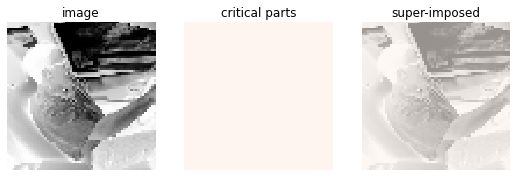

  display_weight:


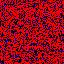

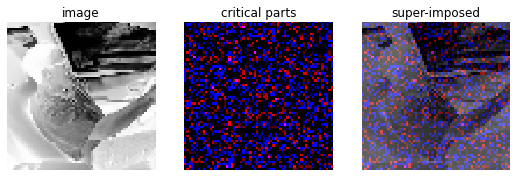

  Proba:
[ 0.9169  0.      0.      0.      0.083   0.      0.      0.0001  0.      0.    ]
min Pby for cls: c0; desc: normal driving; proba: 0.9169; nObs: 1
  img_23350.jpg:
  plot_occlusion:


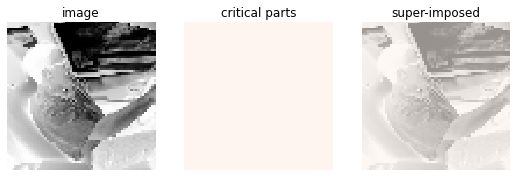

  display_weight:


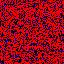

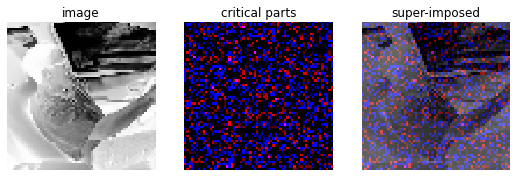

  Proba:
[ 0.9169  0.      0.      0.      0.083   0.      0.      0.0001  0.      0.    ]
  next best class: talking on the phone - left


max Pby for cls: c2; desc: talking on the phone - right; proba: 1.0000; nObs: 179
  img_8759.jpg:
  plot_occlusion:


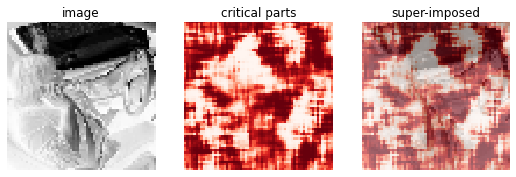

  display_weight:


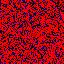

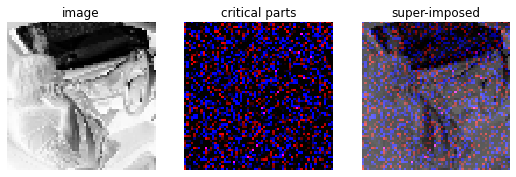

  Proba:
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c2; desc: talking on the phone - right; proba: 0.4792; nObs: 1
  img_21880.jpg:
  plot_occlusion:


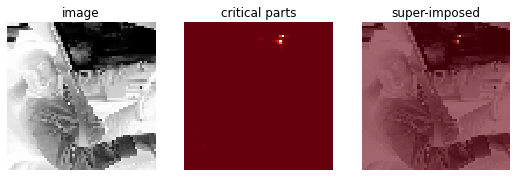

  display_weight:


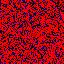

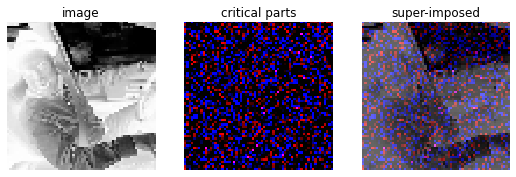

  Proba:
[ 0.      0.      0.4792  0.425   0.      0.      0.      0.0957  0.      0.    ]
  next best class: texting - left


max Pby for cls: c3; desc: texting - left; proba: 1.0000; nObs: 440
  img_29251.jpg:
  plot_occlusion:


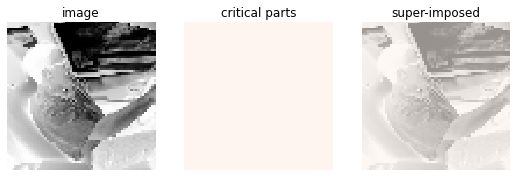

  display_weight:


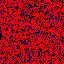

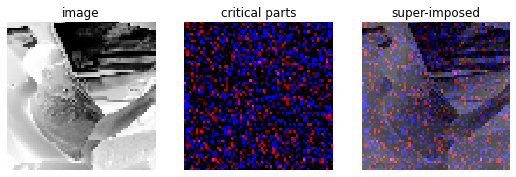

  Proba:
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c3; desc: texting - left; proba: 0.4872; nObs: 1
  img_74128.jpg:
  plot_occlusion:


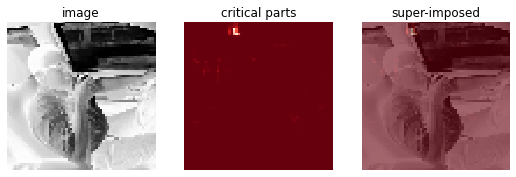

  display_weight:


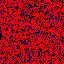

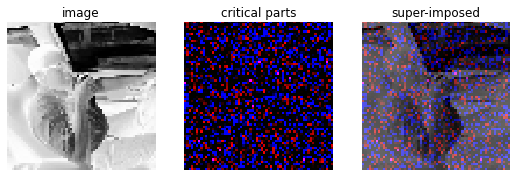

  Proba:
[ 0.      0.      0.4701  0.4872  0.      0.      0.      0.0427  0.      0.    ]
  next best class: talking on the phone - right


max Pby for cls: c4; desc: talking on the phone - left; proba: 0.9905; nObs: 1
  img_53159.jpg:
  plot_occlusion:


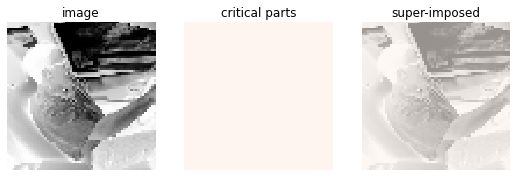

  display_weight:


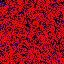

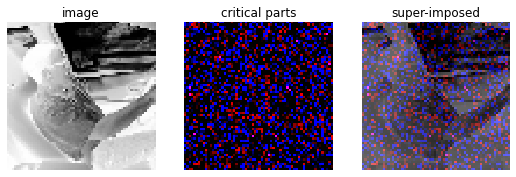

  Proba:
[ 0.      0.      0.0023  0.0072  0.9905  0.      0.      0.      0.      0.    ]
min Pby for cls: c4; desc: talking on the phone - left; proba: 0.9905; nObs: 1
  img_53159.jpg:
  plot_occlusion:


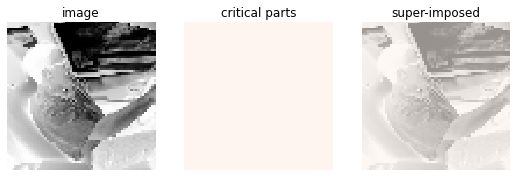

  display_weight:


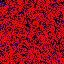

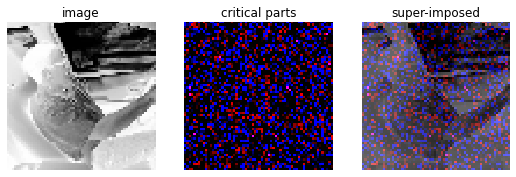

  Proba:
[ 0.      0.      0.0023  0.0072  0.9905  0.      0.      0.      0.      0.    ]
  next best class: texting - left


max Pby for cls: c6; desc: drinking; proba: 0.8050; nObs: 1
  img_22902.jpg:
  plot_occlusion:


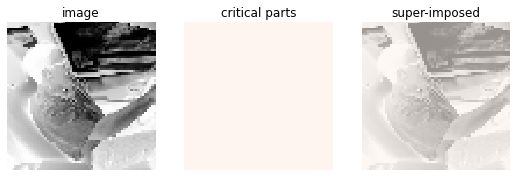

  display_weight:


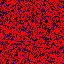

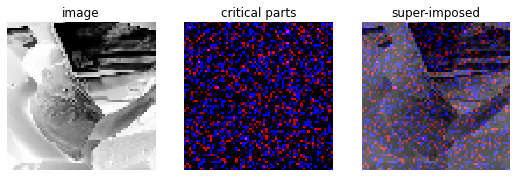

  Proba:
[ 0.      0.018   0.1439  0.      0.0332  0.      0.805   0.      0.      0.    ]
min Pby for cls: c6; desc: drinking; proba: 0.8050; nObs: 1
  img_22902.jpg:
  plot_occlusion:


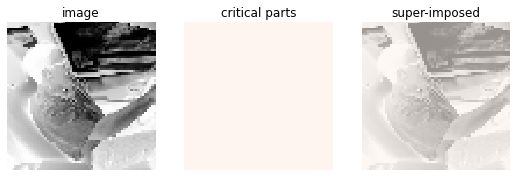

  display_weight:


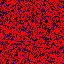

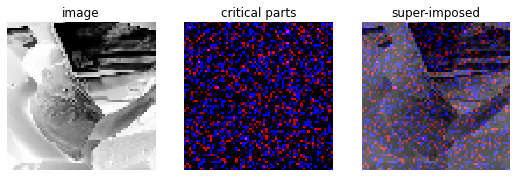

  Proba:
[ 0.      0.018   0.1439  0.      0.0332  0.      0.805   0.      0.      0.    ]
  next best class: talking on the phone - right


max Pby for cls: c7; desc: reaching behind; proba: 1.0000; nObs: 4
  img_91808.jpg:
  plot_occlusion:


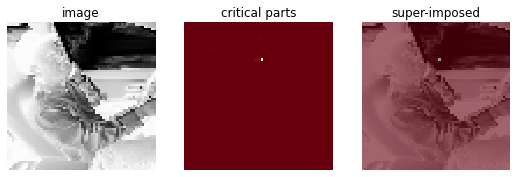

  display_weight:


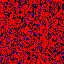

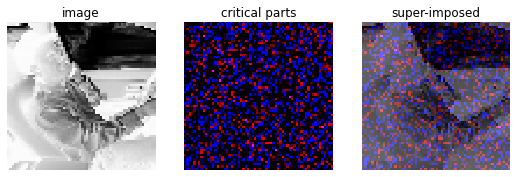

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
min Pby for cls: c7; desc: reaching behind; proba: 0.5289; nObs: 1
  img_35334.jpg:
  plot_occlusion:


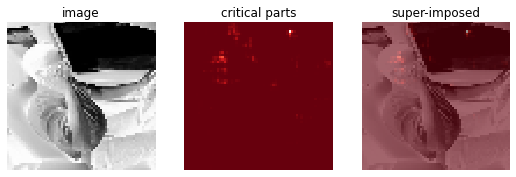

  display_weight:


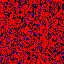

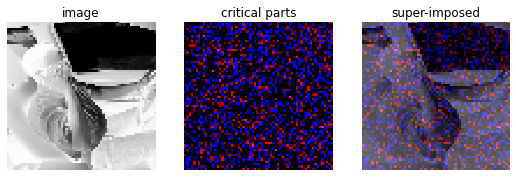

  Proba:
[ 0.      0.      0.0049  0.4662  0.      0.      0.      0.5289  0.      0.    ]
  next best class: texting - left
  duration: 26 seconds

Logistic Regression (TensorFlow): nObsFit:  100; nObsBtc:   16; rotatePby: 0.2000; rotateMaxAgl:  10; nStepsTfw:   10; lrnRateTfw:0.5000 
  visualize: False; newObs: True; verbose: False
  predicting 79726 new obs...
  duration: 13 seconds

Logistic Regression (TensorFlow): nObsFit:  100; nObsBtc:   16; rotatePby: 0.2000; rotateMaxAgl:  10; nStepsTfw:   10; lrnRateTfw:0.5000 
  visualize: False; newObs: False; verbose: True
('  tfwW:', <tf.Tensor 'Identity:0' shape=(4096, 10) dtype=float32>)
('  tfwB:', <tf.Tensor 'Identity_1:0' shape=(10,) dtype=float32>)
  Initialized
  step     1(    0 secs): Minibatch rotation:angle: 3.9074
  step     6(    0 secs): Minibatch rotation:angle: 6.9499

  Vld accuracy:0.1049
[ 0.      0.      0.5111  0.5056  0.      0.      0.      0.0029  0.      0.    ]
[[  0   0 308 174   0   0   0   2   0   0]
 [  0   

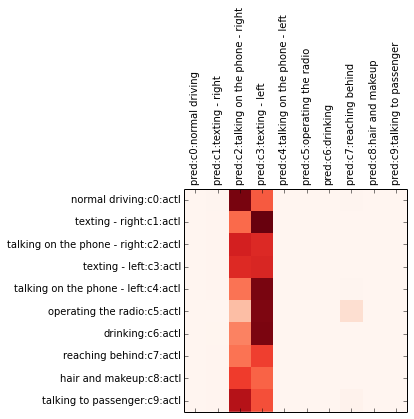


  Vld  logLoss:26.7370
[ 3.8456  3.6906  0.3847  0.3825  3.5034  3.353   3.5066  1.5953  2.8921
  3.5831]
  duration: 01 seconds

Logistic Regression (TensorFlow): nObsFit:  100; nObsBtc:   16; rotatePby: 0.2000; rotateMaxAgl:  10; nStepsTfw:   10; lrnRateTfw:0.5000 
  visualize: False; newObs: False; verbose: False
  duration: 00 seconds

tmpMdlDf: 
   accVld                                          accVldCls  duration  \
0  0.1049  {u'accCls': [0.0, 0.0, 0.511061946903, 0.50564...        26   
0  0.1049  {u'accCls': [0.0, 0.0, 0.511061946903, 0.50564...        13   
0  0.1049  {u'accCls': [0.0, 0.0, 0.511061946903, 0.50564...         1   
0  0.1049  {u'accCls': [0.0, 0.0, 0.511061946903, 0.50564...         0   

               id  logLossVld  \
0  LgtRgr.SGD.tfw   26.737001   
0  LgtRgr.SGD.tfw   26.737001   
0  LgtRgr.SGD.tfw   26.737001   
0  LgtRgr.SGD.tfw   26.737001   

                                       logLossVldCls  lrnRateTfw  \
0  {u'logLossCls': [3.84558724986, 3.6906

In [9]:
%run img_glbSpec_SFDD_ImgSz_64.py
%run img_utils.py

# Add parameter for lrnRateTfw = 0.5 for GradientDescentOptimizer

# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
def fitMdlLgtRgrSGDTfw(lclXFit, lclYFit, 
            nObsFit = 100, nObsBtc = 16, 
            rotatePby = 0.1, rotateMaxAgl = 5,
            nStepsTfw = 10, lrnRateTfw = 0.1,
                    visualize = False, newObs = False, verbose = False):
    
    from scipy.ndimage import rotate    
    from sklearn import metrics as skl_metrics
    
    prtStr = '\nLogistic Regression (TensorFlow): ' + \
          "nObsFit:%5d; nObsBtc:%5d; " + \
          "rotatePby: %.4f; rotateMaxAgl: %3d; " + \
          "nStepsTfw:%5d; lrnRateTfw:%.4f "
    print(prtStr % ( \
            nObsFit, nObsBtc, \
            rotatePby, rotateMaxAgl, \
            nStepsTfw, lrnRateTfw))
    print("  visualize: %s; newObs: %s; verbose: %s" % ( \
            visualize, newObs, verbose))
    
    # Ensure each Fit obs used at least once during training
    if (nStepsTfw * nObsBtc < nObsFit):
        print "  nStepsTfw * nObsBtc < nObsFit: %5d < %5d" % (\
                    nStepsTfw * nObsBtc, nObsFit)
        nStepsTfw = nObsFit / nObsBtc + 1 
        print "  overriding nStepsTfw: %5d" % (nStepsTfw)
    
    startTm = datetime.now()

    mdlDf = pd.DataFrame({'id': 'LgtRgr.SGD.tfw',
                             'nObsFit': [nObsFit],
                             'nObsBtc': [nObsBtc],
                           'rotatePby': [rotatePby],
                        'rotateMaxAgl': [rotateMaxAgl],
                           'nStepsTfw': [nStepsTfw],
                          'lrnRateTfw': [lrnRateTfw]
                         })
    
    graph = tf.Graph()
    with graph.as_default():

      # Input data.
      # The training data, we use a placeholder that will be fed
      #   at run time with a training minibatch.
      # The validation data into constants that 
      #  are attached to the graph.
      # The tests data is loaded by batch thru a placeholder
#       tfwXFit = tf.constant(lclXFit[:nObsFit, :])
#       tfwYFit = tf.constant(lclYFit[:nObsFit])
      tfwXFit = tf.placeholder(tf.float32,
                    shape = (nObsBtc, lclXFit.shape[1]))
      tfwYFit = tf.placeholder(tf.float32, 
                    shape = (nObsBtc, lclYFit.shape[1]))
      tfwXVld = tf.constant(glbXVld)
      tfwYVld = tf.constant(glbYVld)   
      tfwXNew = tf.placeholder(tf.float32, 
                    shape = (glbImg['size'], lclXFit.shape[1]))
      tfwYNew = tf.placeholder(tf.float32, 
                    shape = (glbImg['size'], lclYFit.shape[1]))

      # Variables.
      tf.set_random_seed(glbTfwVarSeed)
    
      # These are the parameters that we are going to be training. 
      # The weight matrix will be initialized using random valued 
      # following a (truncated) normal distribution. 
      # The bias vector get initialized to zero.
      tfwW = tf.Variable(
        tf.truncated_normal([glbImg['size'] * glbImg['size'], 
                             glbRspClassN]), 
        name = 'tfwW')
      tfwB = tf.Variable(tf.zeros([glbRspClassN]), name = 'tfwB')
      if (verbose):  
          print('  tfwW:', tfwW.initialized_value())
          print('  tfwB:', tfwB.initialized_value())
#         print 'lblIx:%2d:%s'% \
#     (np.vectorize("%.4e".__mod__)(tfwW.value()[:5, lblIx]))

      # Training computation.
      # We multiply the inputs with the weight matrix, and add bias. 
      # We compute the softmax and cross-entropy (it's one operation in
      # TensorFlow, because it's very common, and it can be optimized). 
      # We take the average of this cross-entropy across all training 
      # examples: that's our loss.
      logits = tf.matmul(tfwXFit, tfwW) + tfwB
      loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tfwYFit))

      # Optimizer.
      # We are going to find the minimum of this loss using 
      #  gradient descent.
      optimizer = (tf.train
                   .GradientDescentOptimizer(tf.to_float(lrnRateTfw))
                   .minimize(loss))

      # Predictions for the training, validation, and test data.
      # These are not part of training, but merely here so that we can
      # report accuracy_score figures as we train.
      tfwYFitPby = tf.nn.softmax(logits)
      tfwYVldPby = tf.nn.softmax(tf.matmul(tfwXVld, tfwW) + tfwB)
      tfwYNewPby = tf.nn.softmax(tf.matmul(tfwXNew, tfwW) + tfwB)
    
    def accuracy_score(predictions, labels):
      return (1.0 * np.sum(np.argmax(predictions, 1) == 
                           np.argmax(labels, 1))
              / predictions.shape[0])

    tf.set_random_seed(glbTfwVarSeed)
    # For image rotation in feed_dict. Separate seed to ensure 
    #   deterministic performance by tf session irrespective of 
    #   rotation randomization
    np.random.seed(glbNPySeed) 
    with tf.Session(graph=graph) as session:
      # This is a one-time operation which ensures the parameters get
      # initialized as we described in the graph: 
      # random tfwW for the matrix, zeros for the tfwB. 
      tf.initialize_all_variables().run()
      if verbose:
          print('  Initialized')
        
      # Create a dummy feed for test data & occlusion visualization
#       btcNewDct = {tfwXNew: glbXNew[:glbImg['size'], :]}
      for step in range(int(nStepsTfw)):
        
        # Pick an offset within the training data, which has been 
        #   randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * nObsBtc) % (nObsFit - nObsBtc)
        # Generate a minibatch (w/ or w/o rotation)
        if (np.random.rand() > rotatePby):
            btcXFit = lclXFit[offset:(offset + nObsBtc), :]
        else:
            rawXFit = np.reshape(lclXFit[offset:(offset + nObsBtc), :],
                            (nObsBtc, glbImg['size'], glbImg['size']))
            rttXFit = np.zeros_like(rawXFit)
            angle = (np.random.rand() - 0.5) * 2 * rotateMaxAgl
            if (verbose): 
                prtStr = '  step %5d(%5d secs): Minibatch rotation:' + \
                         "angle: %.4f"
                print(prtStr % \
                    (step, thsDrn, \
                     angle))            
#             print '  rawXFit.shape: %s' % (str(rawXFit.shape))
            for ix in xrange(rawXFit.shape[0]):                
#                 if (ix % 10 == 0): 
#                     print '    rawXFit[ix, :, :].shape: %s' % \
#                         (str(rawXFit[ix, :, :].shape))                
                rttXFit[ix, :, :] = rotate(rawXFit[ix, :, :], angle, 
                                        mode = 'nearest', reshape = False)
            btcXFit = np.reshape(rttXFit, 
                        (nObsBtc, glbImg['size'] * glbImg['size']))
            
        btcYFit = lclYFit[offset:(offset + nObsBtc), :]
        
        # Prepare a dictionary telling the session where to feed the 
        #   minibatch. The key of the dictionary is the placeholder node
        #   of the graph to be fed, and the value is the numpy array to 
        #   feed to it.
        feed_dict = {tfwXFit: btcXFit, tfwYFit: btcYFit,
                     tfwXNew: glbXNew[:glbImg['size'], :]}        
        
        # Run the computations. 
        # We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned
        # as numpy arrays.
        _, l, predictions = \
            session.run([optimizer, loss, tfwYFitPby], 
                        feed_dict = feed_dict)
            
        if mydspVerboseTrigger(step):
          thsDrn = (datetime.now() - startTm).seconds  
          if (thsDrn > 100):
              prtStr = '  step %5d(%5d secs): Minibatch ' + \
                        "accuracy: %.4f; logloss: %.4f"  
              print(prtStr % \
                    (step, thsDrn, 
                     accuracy_score(predictions, btcYFit), l))
        
#       accFit = accuracy_score(tfwYFitPby.eval()[:nObsFit, :], 
#                               tfwYFit.eval()   [:nObsFit, :])
#       logLossFit = \
#         skl_metrics.log_loss(tfwYFit.eval()   [:nObsFit, :], 
#                              tfwYFitPby.eval()[:nObsFit, :])
#       if verbose:
#         print '\n  Fit accuracy:%0.4f' % (accFit)
#         print   '  Fit  logLoss:%0.4f' % (logLossFit)        
    #         print metrics.confusion_matrix(glbYFit[0:nObsFit], 
    #                                         lclYFitPdn)        

      # Calling .eval() on tfwObsVldPred is basically like calling run(), 
      # but just to get that one numpy array. 
      # Note that it recomputes all its graph dependencies.

      lclYVldPby = tfwYVldPby.eval()
      lclYVldPdn = np.argmax(lclYVldPby, 1)
      mdlDf['accVld'] = accVld = accuracy_score(lclYVldPby, glbYVld)
      cnfYVld = skl_metrics.confusion_matrix(glbObsVldRsp, lclYVldPdn)
      accYVldCls = cnfYVld.diagonal() * 1.0 / cnfYVld.sum(axis = 1)
      mdlDf['accVldCls'] = None
      mdlDf.set_value(0, 'accVldCls', {'accCls' : accYVldCls})
    
      mdlDf['logLossVld'] = logLossVld = skl_metrics.log_loss(
                                                glbYVld, lclYVldPby)
      logLossVldCls = mygetMetricLogLoss(glbYVld, lclYVldPby, 
                                         returnTyp = 'class')
      mdlDf['logLossVldCls'] = None
      mdlDf.set_value(0, 'logLossVldCls', 
                      {'logLossCls' : logLossVldCls})

      if verbose:
        print '\n  Vld accuracy:%0.4f' % (accVld)
        print accYVldCls
        print cnfYVld
        yLbl = [glbRspClassDesc[glbRspClass[ix]] + ':' + \
                  glbRspClass[ix] + ':actl' \
                for ix in xrange(glbRspClassN)]
        xLbl = ['pred:' + glbRspClass[ix] + ':' + \
                glbRspClassDesc[glbRspClass[ix]] \
                   for ix in xrange(glbRspClassN)]
        # print labels
        plt.matshow(cnfYVld, cmap='Reds', interpolation='none')
        plt.yticks(np.arange(10), yLbl)
        plt.xticks(np.arange(10), xLbl, rotation=90);
        plt.show()

        print '\n  Vld  logLoss:%0.4f' % (logLossVld)
        print logLossVldCls

      if visualize:
        mydisplayImagePredictions(session, tfwW.eval(),
                glbIVld, glbObsVldFtr, glbObsVldRsp, lclYVldPby, 
                glbRspClass, glbRspClassDesc, imgVisualFn = None, 
                            tfwXOcc = tfwXNew, tfwYOccPby = tfwYNewPby)    
            
      if newObs:
          print "  predicting %5d new obs..." % (glbYNew.shape[0])  
          lclYNewPby = np.zeros((glbYNew.shape[0], 
                                 tfwYFitPby.get_shape().as_list()[1]))
          lclYNewPby[:, :] = -1.0
          btcSz = tfwXNew.get_shape().as_list()[0]  
          for obsIx in xrange(0, glbYNew.shape[0], btcSz):
            if mydspVerboseTrigger(obsIx) and \
              (datetime.now() - startTm).seconds > 60:
                print "    @%5d secs: obsIx: %5d" % \
                    ((datetime.now() - startTm).seconds, obsIx)    
            obsEnd = obsIx + btcSz
            if obsEnd > lclYNewPby.shape[0]: 
                obsEnd = lclYNewPby.shape[0]                
            btcYNewPby = session.run(tfwYNewPby, 
                feed_dict = {tfwXNew: glbXNew[obsIx:obsEnd, :] \
                    if obsEnd != lclYNewPby.shape[0] \
                    else np.vstack((glbXNew[obsIx:obsEnd, :], 
                            glbXNew[0:((obsIx + btcSz) % obsEnd), :]))
                                })
            lclYNewPby[obsIx:obsEnd, :] = btcYNewPby[:, :] \
                                if obsEnd != lclYNewPby.shape[0] \
                                else btcYNewPby[:(obsEnd - obsIx), :]    
          
          assert (lclYNewPby[:, :] != -1.0).all(), \
            'some cells in lclYNewPby == -1.0'
#           lclYNewPdn      = tfwYNew.eval()            
#           lclYNewPby = tfwYNewPby.eval()
          lclYNewPdn = np.argmax(lclYNewPby, 1) 
          #if (tfwYNew.eval() > -1).any():
          if (len(np.unique(glbYNew, return_counts = True)[0]) > 1):        
              mdlDf['accNew'] = accNew = accuracy_score(lclYNewPby, 
                                                        glbYNew)
              mdlDf['logLossNew'] = logLossNew = skl_metrics.log_loss(
                                                glbYNew, lclYNewPby)    
              if verbose:      
                print '\n  New accuracy:%0.4f' % (accNew)
                print   '  New  logLoss:%0.4f' % (logLossNew)        
                print skl_metrics.confusion_matrix(glbObsNewRsp, 
                                                   lclYNewPdn)
                yLbl = [glbRspClassDesc[glbRspClass[ix]] + ':' + 
                          glbRspClass[ix] + ':actl' \
                        for ix in xrange(glbRspClassN)]
                xLbl = ['pred:' + glbRspClass[ix] + ':' + \
                        glbRspClassDesc[glbRspClass[ix]] \
                           for ix in xrange(glbRspClassN)]
                # print labels
                plt.matshow(skl_metrics.confusion_matrix(glbObsNewRsp, 
                                                         lclYNewPdn), 
                            cmap='Reds', interpolation='none')
                plt.yticks(np.arange(10), yLbl)
                plt.xticks(np.arange(10), xLbl, rotation=90);
                plt.show()
                
          if visualize:      
              mydisplayImagePredictions(session, tfwW.eval(),
                glbINew, glbObsNewFtr, glbObsNewRsp, lclYNewPby, 
                glbRspClass, glbRspClassDesc, imgVisualFn = None, 
                        tfwXOcc = tfwXNew, tfwYOccPby = tfwYNewPby)    

          mdlDf['predNew'] = None
          mdlDf.set_value(0, 'predNew', {'kntCls' : np.unique(lclYNewPdn, 
                                            return_counts = True)})
          if verbose:
            print '\n  New prediction knts:'
            print mdlDf['predNew'][0]
            
      # indentation (6 spaces) determines scope of this
      #   before session.__exit__ & graph.__exit__        
      mdlDf['model'] = session 
    
    mdlDf['duration'] = (datetime.now() - startTm).seconds  
    print('  duration: %.2d seconds' % (mdlDf['duration'][0]))  
    
    if not newObs: lclYNewPby = None
    return(mdlDf, lclYVldPby, lclYNewPby)

tmpMdlDf = pd.DataFrame()

# thsMdlDf, thsYVldPby, thsYNewPby = fitMdlLgtRgrSGDTfw(
#     glbXFit, glbYFit, 
#     nObsFit = 100, nObsBtc = 16, 
#     rotatePby = 0.2, rotateMaxAgl = 10,
#     nStepsTfw = 10, lrnRateTfw = 0.5,
#     visualize = True, newObs = True, verbose = True)
# tmpMdlDf = tmpMdlDf.append(thsMdlDf)

# To check if model results are deterministic & 
# all run options work separately
thsMdlDf, thsYVldPby, thsYNewPby = fitMdlLgtRgrSGDTfw(
    glbXFit, glbYFit, 
    nObsFit = 100, nObsBtc = 16, 
    rotatePby = 0.2, rotateMaxAgl = 10,    
    nStepsTfw = 10, lrnRateTfw = 0.5, 
    visualize = True, newObs = False, verbose = False)
tmpMdlDf = tmpMdlDf.append(thsMdlDf)

thsMdlDf, thsYVldPby, thsYNewPby = fitMdlLgtRgrSGDTfw(
    glbXFit, glbYFit, 
    nObsFit = 100, nObsBtc = 16, 
    rotatePby = 0.2, rotateMaxAgl = 10,    
    nStepsTfw = 10, lrnRateTfw = 0.5, 
    visualize = False, newObs = True, verbose = False)
tmpMdlDf = tmpMdlDf.append(thsMdlDf)

thsMdlDf, thsYVldPby, thsYNewPby = fitMdlLgtRgrSGDTfw(
    glbXFit, glbYFit, 
    nObsFit = 100, nObsBtc = 16, 
    rotatePby = 0.2, rotateMaxAgl = 10,    
    nStepsTfw = 10, lrnRateTfw = 0.5, 
    visualize = False, newObs = False, verbose = True)
tmpMdlDf = tmpMdlDf.append(thsMdlDf)

thsMdlDf, thsYVldPby, thsYNewPby = fitMdlLgtRgrSGDTfw(
    glbXFit, glbYFit, 
    nObsFit = 100, nObsBtc = 16, 
    rotatePby = 0.2, rotateMaxAgl = 10,
    nStepsTfw = 10, lrnRateTfw = 0.5,
    visualize = False, newObs = False, verbose = False)
tmpMdlDf = tmpMdlDf.append(thsMdlDf)

print '\ntmpMdlDf: '
print(tmpMdlDf)


Logistic Regression (TensorFlow): nObsFit: 1000; nStepsTfw:  100; lrnRateTfw:0.1000
  visualize: False; newObs: True; verbose: True
('  tfwW:', <tf.Tensor 'Identity:0' shape=(4096, 10) dtype=float32>)
('  tfwB:', <tf.Tensor 'Identity_1:0' shape=(10,) dtype=float32>)
  Initialized

  Fit accuracy:0.2470
  Fit  logLoss:7.2014

  Vld accuracy:0.1735
  Vld  logLoss:12.6001
[[ 73  22  44  15  77   7  94  50  18  84]
 [ 33  68  51  31  24  22  90  77  10  72]
 [ 14 100  61   9 115   1  28 113   2   9]
 [  2  18  29 136  34   7  37  19  10 151]
 [  5  14  17 137  67   9  58  91   3  58]
 [ 11  16  19  41 114  13  14 151  30  13]
 [  9  47  31  55 113   9  45  96  19  19]
 [  1  16  10  14  57  28  45 130  24  25]
 [ 21  12  47  36  47  16  50  66   8  61]
 [  2  12  15   8  38   9  56 140  19 153]]


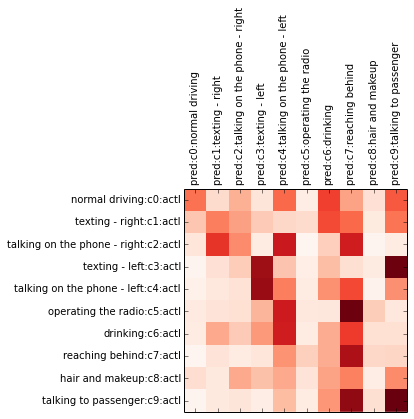

  predicting 79726 new obs...

  New prediction knts:
{'clsKnt': (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 8786, 11144, 10374,  6453,  5874,  4904,  9130,  6548,  7613,  8900]))}
  duration: 19 seconds


In [30]:
lr1MdlDf, lr1YVldPby, lr1YNewPby = fitMdlLgtRgrTfw(
    glbXFit, glbYFit, 
    nObsFit = 1000, nStepsTfw = 100, lrnRateTfw = 0.1, 
    visualize = False, newObs = True, verbose = True)


Logistic Regression (TensorFlow): nObsFit: 1000; nStepsTfw:  100; lrnRateTfw:0.5000
  visualize: False; newObs: True; verbose: True
('  tfwW:', <tf.Tensor 'Identity:0' shape=(4096, 10) dtype=float32>)
('  tfwB:', <tf.Tensor 'Identity_1:0' shape=(10,) dtype=float32>)
  Initialized

  Fit accuracy:0.4970
  Fit  logLoss:5.6870

  Vld accuracy:0.2227
  Vld  logLoss:13.3804
[[148  76  77   0  65   0   4  41   4  69]
 [ 58  87 100   0  44   4   2 121   9  53]
 [ 11  63 120   0 110   0   0 121   0  27]
 [ 10  36  83   1 132   3   3  31   0 144]
 [ 11  19  86   0 197   5  17  53   0  71]
 [ 34   7  66   0  79  35   1 121  38  41]
 [ 33  35 135   0 134   2   1  73   5  25]
 [  2  15  39   0  46  10   0 191  22  25]
 [ 30  24 105   0  40   6   0  62  32  65]
 [ 13  12  87   0  47   6   0 128   3 156]]


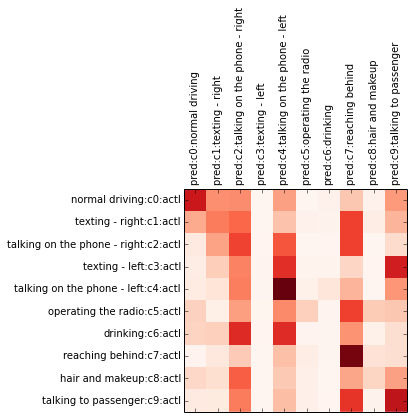

  predicting 79726 new obs...

  New prediction knts:
{'clsKnt': (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([12150, 13070, 22283,   135,  4653,  4845,   390,  7545,  5352,  9303]))}
  duration: 19 seconds


In [31]:
lr5MdlDf, lr5YVldPby, lr5YNewPby = fitMdlLgtRgrTfw(
    glbXFit, glbYFit, 
    nObsFit = 1000, nStepsTfw = 100, lrnRateTfw = 0.5, 
    visualize = False, newObs = True, verbose = True)

In [108]:
%run img_utils.py
from sklearn import metrics as skl_metrics    

def lclaccuracy_score(predictions, labels):
      return (1.0 * np.sum(np.argmax(predictions, 1) == 
                           np.argmax(labels, 1))
              / predictions.shape[0])
    
print "\nlrnRateTfw: 0.1; accVld: %0.4f" % \
    (lclaccuracy_score(lr1YVldPby, glbYVld))
cnf1YVld = skl_metrics.confusion_matrix(glbObsVldRsp, 
                                        np.argmax(lr1YVldPby, 1))
print cnf1YVld
# print cnf1YVld.sum(axis = 1)
print cnf1YVld.diagonal() * 1.0 / cnf1YVld.sum(axis = 1)
# print cnf1YVld.sum(axis = 1).sum()

lls1YVld = skl_metrics.log_loss(glbYVld, lr1YVldPby)
print "\nlrnRateTfw: 0.1; logLossVld: %0.4f" % (lls1YVld)
# lls1YVldCls = np.array([skl_metrics.log_loss(
#                glbYVld[glbYVld[:, clsIx] == 1, :], 
#             lr1YVldPby[glbYVld[:, clsIx] == 1, :]) \
#                      for clsIx in range(glbRspClassN)]) / glbRspClassN
# print "lrnRateTfw: 0.1; logLossVld.skl classSum: %0.4f" % (lls1YVld.sum())
# print lls1YVld
lls1YVldCls = mygetMetricLogLoss(glbYVld, lr1YVldPby, returnTyp = 'class')
print "lrnRateTfw: 0.1; logLossVldCls :"; print lls1YVldCls
# print "diff: %.4e" % (np.abs(lls1YVld - lls1YVldCls.sum()))
assert np.abs(lls1YVld - lls1YVldCls.sum()) < 1e-04, \
    "logLoss from skl: %.4f vs myCls %.4f does not match" % \
    (lls1YVld, lls1YVldCls.sum())
    
print "\nlrnRateTfw: 0.5; accVld: %0.4f" % \
    (lclaccuracy_score(lr5YVldPby, glbYVld))
cnf5YVld = skl_metrics.confusion_matrix(glbObsVldRsp, 
                                        np.argmax(lr5YVldPby, 1))
print cnf5YVld
print cnf5YVld.diagonal() * 1.0 / cnf5YVld.sum(axis = 1)

lls5YVld = skl_metrics.log_loss(glbYVld, lr5YVldPby)
print "\nlrnRateTfw: 0.5; logLossVld: %0.4f" % (lls5YVld)
lls5YVldCls = mygetMetricLogLoss(glbYVld, lr5YVldPby, returnTyp = 'class')
print "lrnRateTfw: 0.5; logLossVldCls :"; print lls5YVldCls
assert np.abs(lls5YVld - lls5YVldCls.sum()) < 1e-04, \
    "logLoss from skl: %.4f vs myCls %.4f does not match" % \
    (lls5YVld, lls5YVldCls.sum())


lrnRateTfw: 0.1; accVld: 0.1735
[[ 73  22  44  15  77   7  94  50  18  84]
 [ 33  68  51  31  24  22  90  77  10  72]
 [ 14 100  61   9 115   1  28 113   2   9]
 [  2  18  29 136  34   7  37  19  10 151]
 [  5  14  17 137  67   9  58  91   3  58]
 [ 11  16  19  41 114  13  14 151  30  13]
 [  9  47  31  55 113   9  45  96  19  19]
 [  1  16  10  14  57  28  45 130  24  25]
 [ 21  12  47  36  47  16  50  66   8  61]
 [  2  12  15   8  38   9  56 140  19 153]]
[ 0.1508  0.1423  0.135   0.307   0.146   0.0308  0.1016  0.3714  0.022
  0.3385]

lrnRateTfw: 0.1; logLossVld: 12.6001
lrnRateTfw: 0.1; logLossVldCls :
[ 1.4741  2.0839  1.4873  0.8025  1.0307  1.8989  1.0157  0.5303  1.2532
  1.0236]

lrnRateTfw: 0.5; accVld: 0.2227
[[148  76  77   0  65   0   4  41   4  69]
 [ 58  87 100   0  44   4   2 121   9  53]
 [ 11  63 120   0 110   0   0 121   0  27]
 [ 10  36  83   1 132   3   3  31   0 144]
 [ 11  19  86   0 197   5  17  53   0  71]
 [ 34   7  66   0  79  35   1 121  38  41]
 [ 33  35

In [10]:
# glbMdlDf = None
# glbMdlDf = pd.DataFrame()

try:
    with open(glbPickleFile['models'], 'rb') as f:
        glbMdlDf = pickle.load(f)
        assert isinstance(glbMdlDf, pd.DataFrame), \
            'type(glbMdlDf): %s, expecting pd.DataFrame' % \
            (str(type(glbMdlDf)))            
except IOError, e:
    print e
    print 'file %s not present or not appropriate' % \
        (glbPickleFile['models'])        
print glbMdlDf

                                                                              accVld  \
id             nStepsTfw nObsFit rotatePby nObsBtc lrnRateTfw rotateMaxAgl             
LgtRgr.skl     -1.0      22424.0 0.0       22424.0 -1.0       0             1.000000   
LgtRgr.tfw      1000.0   22424.0 0.0       22424.0  10.0      0             0.987348   
LgtRgr.SGD.tfw  1000.0   18077.0 0.1       8.0      3.0       2             0.381643   
LgtRgr.tfw      1000.0   18077.0 0.0       18077.0  10.0      0             0.375201   
LgtRgr.SGD.tfw  1000.0   18077.0 0.1       8.0      1.0       2             0.361859   
                                                    2.0       1             0.357488   
                                 0.0       8.0      3.0       0             0.357028   
                                                              2             0.357028   
                                                              1             0.357028   
                                

In [11]:
%run img_utils.py
srchParamsDct = {
    'nObsFit' : [100, 1000, 5000, 6000, 7000, 8000, 9000, 10000, glbObsFitFtr.shape[0]],
#     'nObsFit' : [100, 1000, 5000, 10000, 
#                     glbObsFitFtr.shape[0], glbObsTrnFtr.shape[0]]
    'nObsBtc' : [8],    
#     'nObsBtc' : [4, 8, 16, 32],        
    'rotatePby' : [0.1],
#     'rotatePby' : [0.0, 0.1, 0.2, 0.5],    
    'rotateMaxAgl' : [2],
#     'rotateMaxAgl' : [0, 1, 10],    
    'nStepsTfw' : [1000],
#     'nStepsTfw' : [100, 1000, 10000],    
    'lrnRateTfw' : [3.0]
#     'lrnRateTfw' : [0.1, 0.5, 1.0, 5.0, 7.0, 10.0]    
                }

jnk = mysearchParams(fitMdlLgtRgrSGDTfw, srchParamsDct = srchParamsDct,
                     curResultsDf = glbMdlDf, 
               mode = 'displayonly', 
        sort_values    = ['nObsFit', 'accVld', 'logLossVld', 'duration'],
        sort_ascending = [False    , True    , False,        False],
                save_drop_cols = 'model',     
                save_filepathname = glbPickleFile['models'],
              lclXFit = glbXFit, lclYFit = glbYFit) 

# thsDf, thsObsVldRspPredProba, thsObsNewRspPredProba = fitMdlLgtRgrTfw(
#     glbXFit, glbYFit, 
#     nObsFit = 100, nStepsTfw = 10, lrnRateTfw = 0.5,
#     visualize = False, newObs = False, verbose = False)

mysearchParams: will run <function fitMdlLgtRgrSGDTfw at 0x121d9bf50> with params:
Empty DataFrame
Columns: [nStepsTfw, nObsFit, rotatePby, nObsBtc, lrnRateTfw, rotateMaxAgl]
Index: []
mysearchParams: total runs: 0


In [25]:
%run img_utils.py

glbMdlDf = mysearchParams(fitMdlLgtRgrSGDTfw, srchParamsDct = srchParamsDct,
                     curResultsDf = glbMdlDf, 
               mode = 'run', 
        sort_values    = ['nObsFit', 'accVld', 'logLossVld', 'duration'],
        sort_ascending = [False    , False    , True,        True],       
                save_filepathname = glbPickleFile['models'],
                save_drop_cols = 'model',          
              lclXFit = glbXFit, lclYFit = glbYFit)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:124: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:143: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:126: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


mysearchParams: running <function fitMdlLgtRgrSGDTfw at 0x1181d3f50> with params:
nStepsTfw       1000
nObsFit         6000
rotatePby        0.1
nObsBtc            8
lrnRateTfw         3
rotateMaxAgl       2

Logistic Regression (TensorFlow): nObsFit: 6000; nObsBtc:    8; rotatePby: 0.1000; rotateMaxAgl:   2; nStepsTfw: 1000; lrnRateTfw:3.0000 
  visualize: False; newObs: False; verbose: False
  duration: 09 seconds
mysearchParams: running <function fitMdlLgtRgrSGDTfw at 0x1181d3f50> with params:
nStepsTfw       1000
nObsFit         7000
rotatePby        0.1
nObsBtc            8
lrnRateTfw         3
rotateMaxAgl       2

Logistic Regression (TensorFlow): nObsFit: 7000; nObsBtc:    8; rotatePby: 0.1000; rotateMaxAgl:   2; nStepsTfw: 1000; lrnRateTfw:3.0000 
  visualize: False; newObs: False; verbose: False
  duration: 09 seconds
mysearchParams: running <function fitMdlLgtRgrSGDTfw at 0x1181d3f50> with params:
nStepsTfw       1000
nObsFit         8000
rotatePby        0.1
nObsBtc        

In [16]:
lrn10Srs = glbMdlDf.ix[('LgtRgr.tfw',  1000.0,   18077.0,  10.0)]
# print lrn10Srs
lrn01Srs = glbMdlDf.ix[('LgtRgr.tfw',  1000.0,   18077.0,   1.0)]
# print lrn01Srs

print "lrn10Srs: accVld: %.4f" % (lrn10Srs['accVld'])
print "lrn01Srs: accVld: %.4f" % (lrn01Srs['accVld'])
print "lrn10-01: accVldDff: %.4f" % (lrn10Srs['accVld'] - lrn01Srs['accVld'])

print "lrn10Srs: accVldCls:"; print (lrn10Srs['accVldCls']['accCls'])
print "lrn01Srs: accVldCls:"; print (lrn01Srs['accVldCls']['accCls'])
print "lrn10-01: accVldClsDff:"; print (lrn10Srs['accVldCls']['accCls'] - 
                                        lrn01Srs['accVldCls']['accCls'])

print "\n"
print "lrn10Srs: logLossVld: %8.4f" % (lrn10Srs['logLossVld'])
print "lrn01Srs: logLossVld: %8.4f" % (lrn01Srs['logLossVld'])
print "lrn10-01: logLossVldDff: %8.4f" % (lrn10Srs['logLossVld'] - 
                                          lrn01Srs['logLossVld'])

print "lrn10Srs: logLossVldCls:"; print (lrn10Srs['logLossVldCls']['logLossCls'])
print "lrn01Srs: logLossVldCls:"; print (lrn01Srs['logLossVldCls']['logLossCls'])
print "lrn10-01: logLossVldClsDff:"; 
print (lrn10Srs['logLossVldCls']['logLossCls'] - 
       lrn01Srs['logLossVldCls']['logLossCls'])

lrn10Srs: accVld: 0.3752
lrn01Srs: accVld: 0.3202
lrn10-01: accVldDff: 0.0550
lrn10Srs: accVldCls:
[ 0.5041  0.4351  0.3805  0.1738  0.3965  0.2464  0.6749  0.5143  0.25
  0.1637]
lrn01Srs: accVldCls:
[ 0.3264  0.2092  0.2323  0.2144  0.3878  0.1588  0.6637  0.6286  0.2088
  0.219 ]
lrn10-01: accVldClsDff:
[ 0.1777  0.2259  0.1482 -0.0406  0.0087  0.0877  0.0113 -0.1143  0.0412
 -0.0553]


lrn10Srs: logLossVld:  19.2099
lrn01Srs: logLossVld:   9.4750
lrn10-01: logLossVldDff:   9.7349
lrn10Srs: logLossVldCls:
[ 1.726   1.7854  1.8043  2.6157  1.9122  2.3841  0.9763  1.0939  1.9704
  2.9416]
lrn01Srs: logLossVldCls:
[ 1.0565  1.4437  0.9226  1.0162  0.8034  1.5807  0.2146  0.2664  0.879
  1.2919]
lrn10-01: logLossVldClsDff:
[ 0.6695  0.3417  0.8817  1.5995  1.1088  0.8034  0.7616  0.8275  1.0915
  1.6497]


In [43]:
# Set value based on condition

# print glbMdlDf.ix[glbMdlDf['id'].str.contains('LogisticRegression.SGD.tf', 
#                                               na=False), 'id']
# glbMdlDf.ix[glbMdlDf['id'].str.contains('LogisticRegression.SGD.tf', 
#                                               na=False), 'id'] = 'LgtRgr.SGD.tf'
# print glbMdlDf.ix[glbMdlDf['id'].str.contains('LogisticRegression.SGD.tf', 
#                                               na=False), 'id']

def lclfixNanDf(df, column, default):
    print "\n Before:"
    dspDf = df[[column]]
    dspDf[column + '.isnull'] = df[column].isnull()
    print dspDf.to_string(index = False)
    
    df.loc[df[column].isnull(), column] = default
    
    print "\n After:"
    dspDf = df[[column]]
    dspDf[column + '.isnull'] = df[column].isnull()
    print dspDf.to_string(index = False)    
    return(df)

# tmpMdlDf = lclfixNanDf(glbMdlDf, column = 'rotatePby', default = 0)

# print glbMdlDf.ix[- glbMdlDf['nStepsTfw'].isnull(), ['id', 'nStepsTfw']]
# glbMdlDf.ix[- glbMdlDf['nStepsTfw'].isnull(), 'id'] = 'LogisticRegression.tf'
# print glbMdlDf.ix[- glbMdlDf['nStepsTfw'].isnull(), ['id', 'nStepsTfw']]

# print glbMdlDf.ix[glbMdlDf['nObsBtc'].isnull(), ['nObsBtc', 'nObsFit']]
# # glbMdlDf.ix[glbMdlDf['nObsBtc'].isnull(), 'nObsBtc'] = \
# #     glbMdlDf.ix[glbMdlDf['nObsBtc'].isnull(), 'nObsFit']
# glbMdlDf['nObsBtc'] = glbMdlDf.apply(
#     lambda (row): row['nObsFit'] if pd.isnull(row['nObsBtc']) else row['nObsBtc'],
#                         axis = 1)
# print 'After:'    
# print glbMdlDf.ix[glbMdlDf['nObsBtc'].isnull(), ['nObsBtc', 'nObsFit']]

# Change value
# tmpMdlDf = glbMdlDf
# print tmpMdlDf[(tmpMdlDf['id'].str.contains('LgtRgr.skl', na = False)) & 
#                (tmpMdlDf['nStepsTfw'] == 1.0)]
# print tmpMdlDf.ix[(tmpMdlDf['id'].str.contains('LgtRgr.skl', na = False)) & 
#                   (tmpMdlDf['nStepsTfw'] == 1.0), 'nStepsTfw']
# tmpMdlDf.ix[(tmpMdlDf['id'].str.contains('LgtRgr.skl', na = False)) & 
#                   (tmpMdlDf['nStepsTfw'] == 1.0), 'nStepsTfw'] = -1.0
# print 'After:'
# print tmpMdlDf

# Remove specific models
# mask = (glbMdlDf['id'].str.contains('LgtRgr.tfw', na = False))
# mask = (glbMdlDf['id'].str.contains('LgtRgr.tfw', na = False)) & \
#        (glbMdlDf['nObsFit'] == 10000.0)
# print mask
# tmpMdlDf = glbMdlDf[~mask]
# print tmpMdlDf

# Remove dups
# print glbMdlDf.columns
# print (glbMdlDf['logLossVld'])
# print (glbMdlDf.index.duplicated())
# tmpMdlDf = glbMdlDf[~glbMdlDf.index.duplicated()]
# print (tmpMdlDf.index.duplicated())

# glbMdlDf['nObsBtc'] = glbMdlDf['nObsFit'] 

# glbMdlDf = tmpMdlDf
# print 'After:'
# print glbMdlDf
print glbMdlDf['bestFit']

id              nStepsTfw  nObsFit  rotatePby  nObsBtc  lrnRateTfw  rotateMaxAgl
LgtRgr.skl      -1.0       22424.0  0.0        22424.0  -1.0        0               False
LgtRgr.tfw       1000.0    22424.0  0.0        22424.0   10.0       0                 NaN
                           18077.0  0.0        18077.0   10.0       0                True
LgtRgr.skl      -1.0       18077.0  0.0        18077.0  -1.0        0               False
LgtRgr.tfw       1000.0    18077.0  0.0        18077.0   1.0        0               False
LgtRgr.skl      -1.0       15000.0  0.0        15000.0  -1.0        0               False
LgtRgr.tfw       1000.0    10000.0  0.0        10000.0   10.0       0               False
LgtRgr.skl      -1.0       10000.0  0.0        10000.0  -1.0        0               False
LgtRgr.tfw       1000.0    10000.0  0.0        10000.0   1.0        0               False
                                                         0.1        0               False
LgtRgr.skl      -1.

In [37]:
myexportDf(glbMdlDf, 
           save_filepathname = glbPickleFile['models'],
           save_drop_cols = 'model'
          )

Compressed pickle file: data/img_M_SFDD_ImgSz_64.pickle; size: 7 KB


In [12]:
glbMdlDf['bestFit'] = False
glbMdlDf.ix[(
 'LgtRgr.SGD.tfw', 1000.0,    18077.0, 0.1,       8.0,     3.0,        2), 
# LgtRgr.SGD.tfw   1000.0     18077.0  0.1        8.0      3.0         2            
# id               nStepsTfw  nObsFit  rotatePby  nObsBtc  lrnRateTfw  rotateMaxAgl
            'bestFit'] = True            
print glbMdlDf[list(set(glbMdlDf.columns) - set(srchParamsDct.keys()))]
# print glbMdlDf[glbMdlDf.nObsFit >= 10000][
#     list(set(glbMdlDf.columns) - set(srchParamsDct.keys()))]

                                                                                                                    accVldCls  \
id             nStepsTfw nObsFit rotatePby nObsBtc lrnRateTfw rotateMaxAgl                                                      
LgtRgr.skl     -1.0      22424.0 0.0       22424.0 -1.0       0                                                           NaN   
LgtRgr.tfw      1000.0   22424.0 0.0       22424.0  10.0      0             {u'accCls': [0.989669421488, 0.991631799163, 0...   
LgtRgr.SGD.tfw  1000.0   18077.0 0.1       8.0      3.0       2             {u'accCls': [0.607438016529, 0.219665271967, 0...   
LgtRgr.tfw      1000.0   18077.0 0.0       18077.0  10.0      0             {u'accCls': [0.504132231405, 0.435146443515, 0...   
LgtRgr.SGD.tfw  1000.0   18077.0 0.1       8.0      1.0       2             {u'accCls': [0.448347107438, 0.44769874477, 0....   
                                                    2.0       1             {u'accCls': [0.338842

/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py:212: PerformanceWarning: indexing past lexsort depth may impact performance.
  handler(stream, idents, msg)


In [4]:
# # With gradient descent training, even this much data is prohibitive.
# # Subset the training data for faster turnaround.
# nObsFit = 10000

# graph = tf.Graph()
# with graph.as_default():

#   # Input data.
#   # Load the training, validation and test data into constants that are
#   # attached to the graph.
#   tfwObsFitFtr = tf.constant(glbXFit[:nObsFit, :])
#   tfwObsFitRsp = tf.constant(glbYFit[:nObsFit])
#   tfwObsVldFtr = tf.constant(glbXVld)
#   tfwObsNewFtr = tf.constant(glbXNew)
  
#   # Variables.
#   # These are the parameters that we are going to be training. The weight
#   # matrix will be initialized using random valued following a (truncated)
#   # normal distribution. The tfwB get initialized to zero.
#   tfwW = tf.Variable(
#     tf.truncated_normal([glbImg['size'] * glbImg['size'], glbRspClassN]), name = 'tfwW')
#   tfwB = tf.Variable(tf.zeros([glbRspClassN]), name = 'tfwB')
#   print(tfwW.initialized_value())
#   print(tfwB.initialized_value())
# #   print 'initial  tfwB:%s' % (np.vectorize("%.4e".__mod__)(tf.get_variable('tfwB')))
# #   print 'initial tfwW (first 5 only):' 
# #   for lblIx in xrange(glbRspClassN):
# #     print 'lblIx:%2d:%s'% (np.vectorize("%.4e".__mod__)(tfwW.value()[:5, lblIx]))
  
#   # Training computation.
#   # We multiply the inputs with the weight matrix, and add tfwB. We compute
#   # the softmax and cross-entropy (it's one operation in TensorFlow, because
#   # it's very common, and it can be optimized). We take the average of this
#   # cross-entropy across all training examples: that's our loss.
#   logits = tf.matmul(tfwObsFitFtr, tfwW) + tfwB
#   loss = tf.reduce_mean(
#     tf.nn.softmax_cross_entropy_with_logits(logits, tfwObsFitRsp))
  
#   # Optimizer.
#   # We are going to find the minimum of this loss using gradient descent.
#   optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
#   # Predictions for the training, validation, and test data.
#   # These are not part of training, but merely here so that we can report
#   # accuracy_score figures as we train.
#   tfwObsTrnPred = tf.nn.softmax(logits)
#   tfwObsVldPred = tf.nn.softmax(
#     tf.matmul(tfwObsVldFtr, tfwW) + tfwB)
#   tfwObsNewPred = tf.nn.softmax(tf.matmul(tfwObsNewFtr, tfwW) + tfwB)

Tensor("Identity:0", shape=TensorShape([Dimension(784), Dimension(10)]), dtype=float32)
Tensor("Identity_1:0", shape=TensorShape([Dimension(10)]), dtype=float32)


Let's run this computation and iterate:

In [58]:
# nStepsTfw = 801

# def accuracy_score(predictions, labels):
#   return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
#           / predictions.shape[0])

# with tf.Session(graph=graph) as session:
#   # This is a one-time operation which ensures the parameters get initialized as
#   # we described in the graph: random tfwW for the matrix, zeros for the
#   # tfwB. 
#   tf.initialize_all_variables().run()
#   print('Initialized')
#   for step in range(nStepsTfw):
#     # Run the computations. We tell .run() that we want to run the optimizer,
#     # and get the loss value and the training predictions returned as numpy
#     # arrays.
#     _, l, predictions = session.run([optimizer, loss, tfwObsTrnPred])
#     if (step % 100 == 0):
#       print('Loss at step %d: %f' % (step, l))
#       print('Training accuracy_score: %.1f%%' % accuracy_score(
#         predictions, glbYFit[:nObsFit, :]))
#       # Calling .eval() on tfwObsVldPred is basically like calling run(), but
#       # just to get that one numpy array. Note that it recomputes all its graph
#       # dependencies.
#       print('Validation accuracy_score: %.1f%%' % accuracy_score(
#         tfwObsVldPred.eval(), glbYVld))
#   print('Test accuracy_score: %.1f%%' % accuracy_score(tfwObsNewPred.eval(), glbYNew))

In [13]:
robjects.pandas2ri.activate()
pltRDf = robjects.conversion.py2ri(glbMdlDf)
# print(pltRDf)
pltRFn = robjects.r("""
    source('~/Dropbox/datascience/R/myplot.R')
    function(RDf, filename) {
        mypltModelStats(RDf, c('accVld', 'logLossVld', 'duration'), 
            dim = c('nObsFit', 'id', 'nStepsTfw', 'lrnRateTfw'), 
                scaleXFn = NULL, 
                #highLightIx = which.min(RDf$logLossVld),
                highLightIx = which(RDf$bestFit == 'TRUE'),                
            title = NULL, 
            fileName = filename)
    }                        
""")    
pltRFn(pltRDf, 'img_04_fit_lgtRgr_SGD_Tfw_SFDD_glbMdlDf.png')

pltRFn = robjects.r("""
    source('~/Dropbox/datascience/R/myplot.R')
    function(RDf, filename) {
        mypltModelStats(RDf, c('accVld', 'logLossVld'), 
            dim = c('nObsFit', 'id', 'nStepsTfw', 'lrnRateTfw'), 
                scaleXFn = NULL, 
                #highLightIx = which.min(RDf$logLossVld),
                highLightIx = which(RDf$bestFit == 'TRUE'),                
            title = NULL, 
            fileName = filename)
    }                        
""")    
pltRFn(pltRDf, 'img_04_fit_lgtRgr_SGD_Tfw_SFDD_glbMdlDf_logLossVld.png')

pltRFn = robjects.r("""
    source('~/Dropbox/datascience/R/myplot.R')
    function(RDf, filename) {
        mypltModelStats(RDf, c('accVld'), 
            dim = c('nObsFit', 'id', 
                    'nObsBtc', 'rotatePby', 'rotateMaxAgl',
                    'nStepsTfw', 'lrnRateTfw'), 
                scaleXFn = NULL, 
                #highLightIx = which.min(RDf$logLossVld),
                highLightIx = which(RDf$bestFit == 'TRUE'),                
            title = NULL, 
            fileName = filename)
    }                        
""")    
pltRFn(pltRDf, 'img_04_fit_lgtRgr_SGD_Tfw_SFDD_glbMdlDf_accVld.png')

pltRFn = robjects.r("""
    source('~/Dropbox/datascience/R/myplot.R')
    function(RDf, filename) {
        mypltModelStats(subset(RDf, 
                            # nObsBtc      %in% c(8, 18077, 22424) &
                                lrnRateTfw   %in% c(-1.0, 3.0, 10.0) &
                                rotatePby    %in% c(0.0, 0.1) &
                                rotateMaxAgl %in% c(0, 2)
                            ),
                measure = c('accVld'),
                dim = c('nObsFit', 'id',
                        # 'nObsBtc',
                        # 'lrnRateTfw',
                        # 'rotatePby',
                        'rotateMaxAgl',
                        'nStepsTfw',
                        NULL),        
                scaleXFn = NULL, 
                #highLightIx = which.min(RDf$logLossVld),
                highLightIx = which(RDf$bestFit == 'TRUE'),                
            title = NULL, 
            fileName = filename)
    }                        
""")    
pltRFn(pltRDf, 'img_04_fit_lgtRgr_SGD_Tfw_SFDD_glbMdlDf_accVldSel.png')

# id nStepsTfw  nObsFit  rotatePby  nObsBtc  lrnRateTfw  rotateMaxAgl

/usr/local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

  res = super(Function, self).__call__(*new_args, **new_kwargs)


<ListVector - Python:0x13c88f320 / R:0x7fe0225c8bf8>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
<ListVector - Python:0x13c88f320 / R:0x7fe0225c8bf8>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
<ListVector - Python:0x13c88f320 / R:0x7fe0225c8bf8>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
  scales: <class 'rpy2.robjects.environments.Environment'>
  <Environment - Python:0x13c869710 / R:0x7fe00b93f778>
  ...
<ListVector - Python:0x13c88f320 / R:0x7fe0225c8bf8>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]
  layers: <class 'rpy2.robjects.environments.Environment'>
  <Environment - Python:0x13c88f098 / R:0x7fe00c39dc08>
<ListVector - Python:0x13c88f320 / R:0x7fe0225c8bf8>
[DataF..., ListV..., Envir..., ..., ListV..., Envir..., ListV...]

In [29]:
glbMdlDf.to_csv('img_04_fit_lgtRgr_SGD_Tfw_SFDD_glbMdlDf.csv')

### Fit selected model to glbObsFit

In [14]:
selMdlSrs = glbMdlDf[glbMdlDf['bestFit']]
print selMdlSrs

                                                                              accVld  \
id             nStepsTfw nObsFit rotatePby nObsBtc lrnRateTfw rotateMaxAgl             
LgtRgr.SGD.tfw 1000.0    18077.0 0.1       8.0     3.0        2             0.381643   

                                                                                                                    accVldCls  \
id             nStepsTfw nObsFit rotatePby nObsBtc lrnRateTfw rotateMaxAgl                                                      
LgtRgr.SGD.tfw 1000.0    18077.0 0.1       8.0     3.0        2             {u'accCls': [0.607438016529, 0.219665271967, 0...   

                                                                           bestFit  \
id             nStepsTfw nObsFit rotatePby nObsBtc lrnRateTfw rotateMaxAgl           
LgtRgr.SGD.tfw 1000.0    18077.0 0.1       8.0     3.0        2               True   

                                                                            duration  \



Logistic Regression (TensorFlow): nObsFit:18077; nObsBtc:    8; rotatePby: 0.1000; rotateMaxAgl:   2; nStepsTfw: 1000; lrnRateTfw:3.0000 
  visualize: True; newObs: True; verbose: True
('  tfwW:', <tf.Tensor 'Identity:0' shape=(4096, 10) dtype=float32>)
('  tfwB:', <tf.Tensor 'Identity_1:0' shape=(10,) dtype=float32>)
  Initialized

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:124: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:143: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:126: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)



  step     1(    0 secs): Minibatch rotation:angle: 0.7815
  step     6(    0 secs): Minibatch rotation:angle: 1.3900
  step    13(    0 secs): Minibatch rotation:angle: 1.4487
  step    34(    0 secs): Minibatch rotation:angle: 0.2647
  step    39(    0 secs): Minibatch rotation:angle: -0.4238
  step    40(    0 secs): Minibatch rotation:angle: -1.0228
  step    42(    1 secs): Minibatch rotation:angle: -1.5997
  step    73(    1 secs): Minibatch rotation:angle: -1.4536
  step    75(    1 secs): Minibatch rotation:angle: 0.7455
  step    78(    1 secs): Minibatch rotation:angle: -0.2561
  step    86(    1 secs): Minibatch rotation:angle: 0.0559
  step    89(    1 secs): Minibatch rotation:angle: 0.8329
  step    93(    1 secs): Minibatch rotation:angle: 0.1879
  step   101(    1 secs): Minibatch rotation:angle: 0.1547
  step   123(    1 secs): Minibatch rotation:angle: 0.4447
  step   134(    1 secs): Minibatch rotation:angle: -1.7246
  step   139(    1 secs): Minibatch rotation:angl

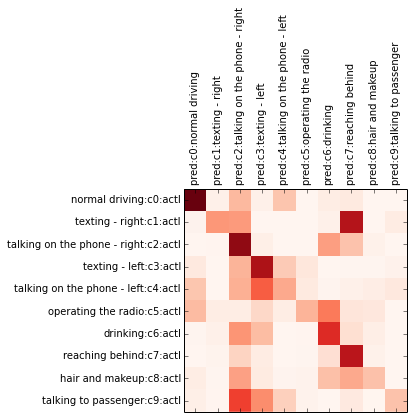


  Vld  logLoss:20.5467
[ 1.4886  2.7646  1.3374  1.4457  2.908   2.6567  1.7421  0.815   2.3394
  3.0493]


max Pby for cls: c0; desc: normal driving; proba: 1.0000; nObs: 421
  img_62023.jpg:
  plot_occlusion:


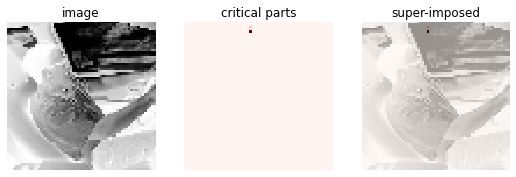

  display_weight:


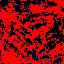

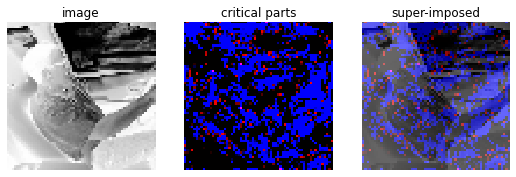

  Proba:
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c0; desc: normal driving; proba: 0.6046; nObs: 1
  img_3899.jpg:
  plot_occlusion:


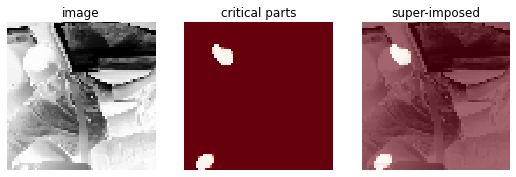

  display_weight:


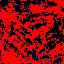

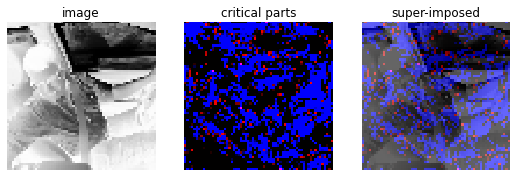

  Proba:
[ 0.6046  0.      0.      0.      0.3954  0.      0.      0.      0.      0.    ]
  next best class: talking on the phone - left


max Pby for cls: c1; desc: texting - right; proba: 1.0000; nObs: 115
  img_53130.jpg:
  plot_occlusion:


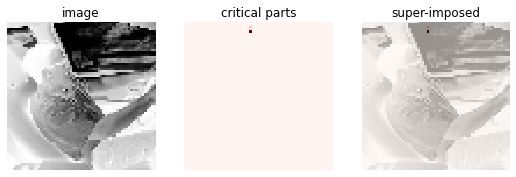

  display_weight:


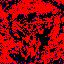

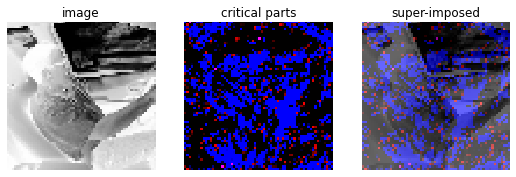

  Proba:
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c1; desc: texting - right; proba: 0.6158; nObs: 1
  img_100358.jpg:
  plot_occlusion:


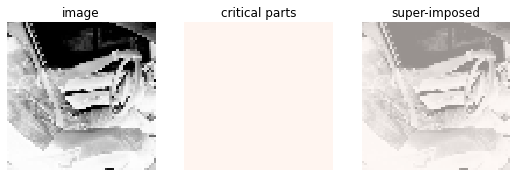

  display_weight:


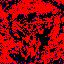

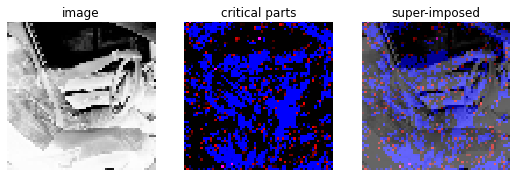

  Proba:
[ 0.      0.6158  0.3842  0.      0.      0.      0.      0.      0.      0.    ]
  next best class: talking on the phone - right


max Pby for cls: c2; desc: talking on the phone - right; proba: 1.0000; nObs: 928
  img_24934.jpg:
  plot_occlusion:


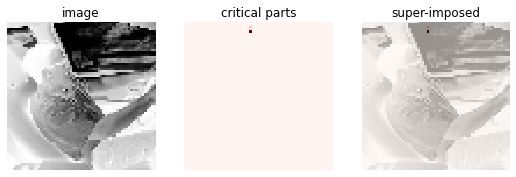

  display_weight:


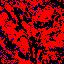

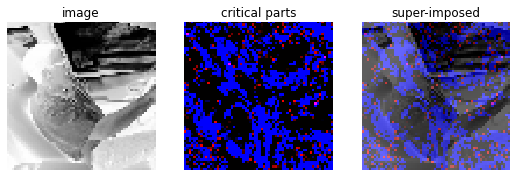

  Proba:
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c2; desc: talking on the phone - right; proba: 0.5197; nObs: 1
  img_52596.jpg:
  plot_occlusion:


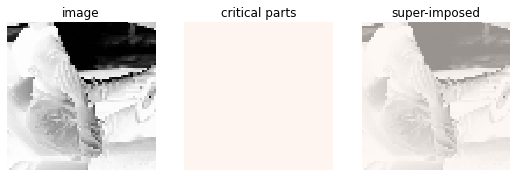

  display_weight:


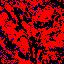

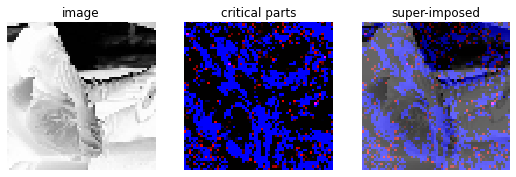

  Proba:
[ 0.      0.      0.5197  0.      0.      0.      0.4803  0.      0.      0.    ]
  next best class: drinking


max Pby for cls: c3; desc: texting - left; proba: 1.0000; nObs: 621
  img_79904.jpg:
  plot_occlusion:


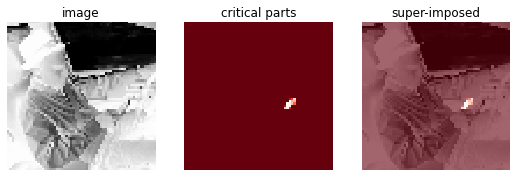

  display_weight:


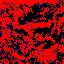

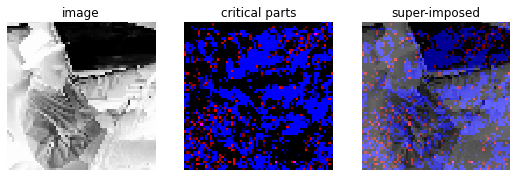

  Proba:
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c3; desc: texting - left; proba: 0.5347; nObs: 1
  img_42027.jpg:
  plot_occlusion:


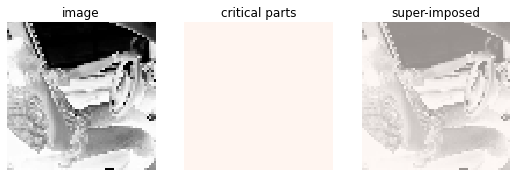

  display_weight:


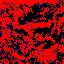

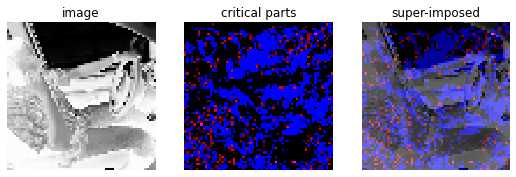

  Proba:
[ 0.      0.      0.      0.5347  0.      0.      0.4653  0.      0.      0.    ]
  next best class: drinking


max Pby for cls: c4; desc: talking on the phone - left; proba: 1.0000; nObs: 261
  img_18343.jpg:
  plot_occlusion:


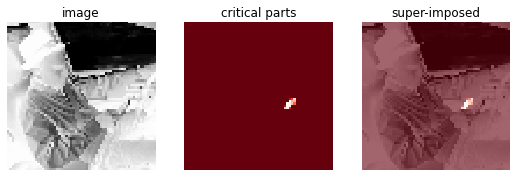

  display_weight:


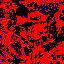

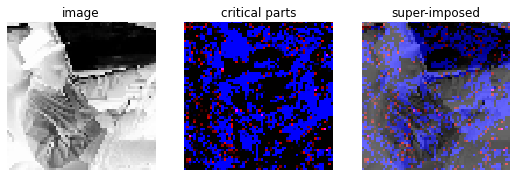

  Proba:
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
min Pby for cls: c4; desc: talking on the phone - left; proba: 0.7097; nObs: 1
  img_27020.jpg:
  plot_occlusion:


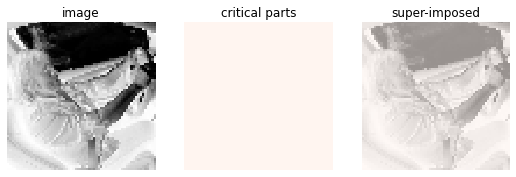

  display_weight:


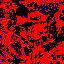

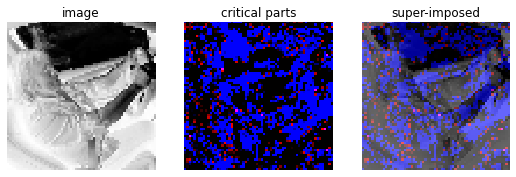

  Proba:
[ 0.      0.      0.      0.      0.7097  0.      0.      0.2903  0.      0.    ]
  next best class: reaching behind


max Pby for cls: c5; desc: operating the radio; proba: 1.0000; nObs: 113
  img_15928.jpg:
  plot_occlusion:


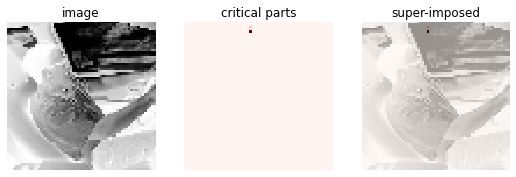

  display_weight:


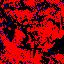

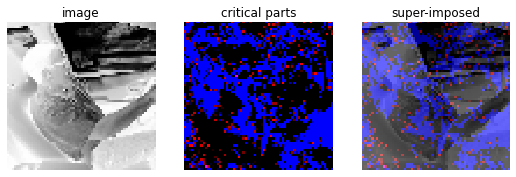

  Proba:
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
min Pby for cls: c5; desc: operating the radio; proba: 0.5496; nObs: 1
  img_13512.jpg:
  plot_occlusion:


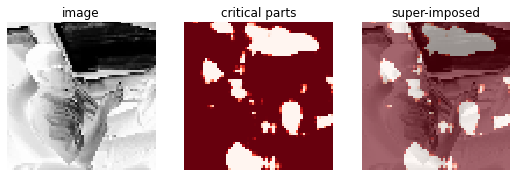

  display_weight:


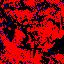

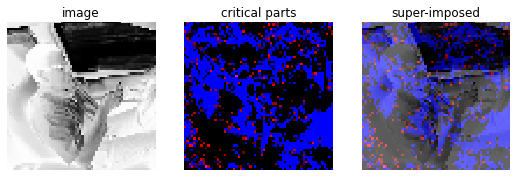

  Proba:
[ 0.      0.      0.      0.4504  0.      0.5496  0.      0.      0.      0.    ]
  next best class: texting - left


max Pby for cls: c6; desc: drinking; proba: 1.0000; nObs: 480
  img_29251.jpg:
  plot_occlusion:


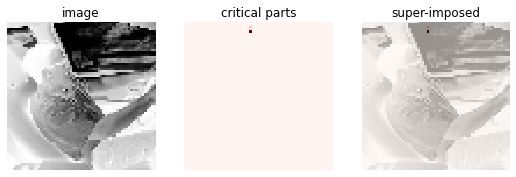

  display_weight:


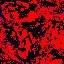

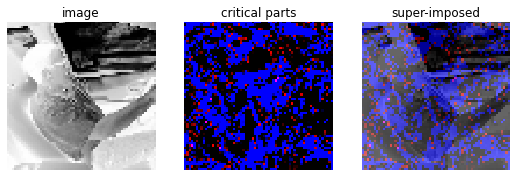

  Proba:
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
min Pby for cls: c6; desc: drinking; proba: 0.5265; nObs: 1
  img_43784.jpg:
  plot_occlusion:


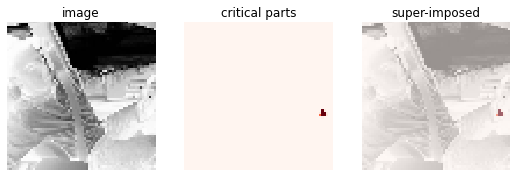

  display_weight:


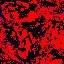

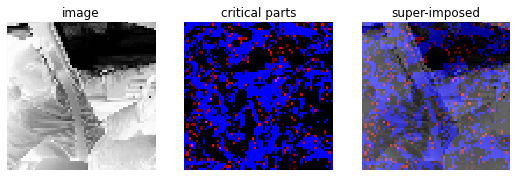

  Proba:
[ 0.      0.      0.      0.      0.      0.4735  0.5265  0.      0.      0.    ]
  next best class: operating the radio


max Pby for cls: c7; desc: reaching behind; proba: 1.0000; nObs: 644
  img_80068.jpg:
  plot_occlusion:


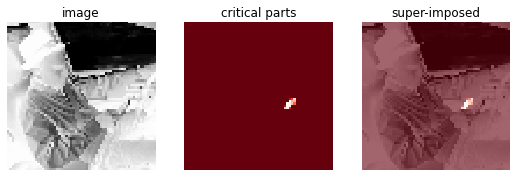

  display_weight:


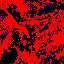

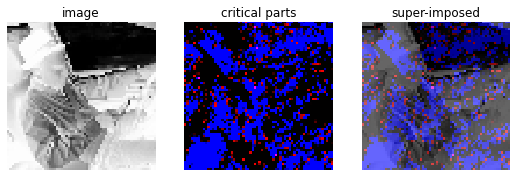

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
min Pby for cls: c7; desc: reaching behind; proba: 0.5231; nObs: 1
  img_30223.jpg:
  plot_occlusion:


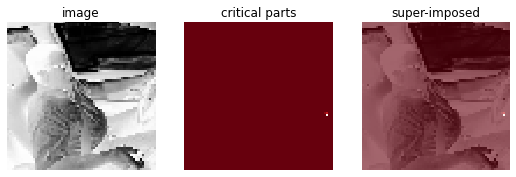

  display_weight:


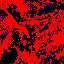

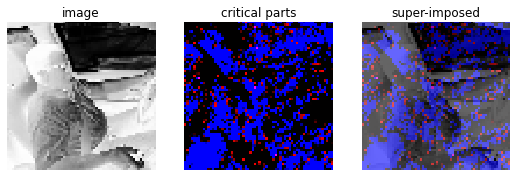

  Proba:
[ 0.      0.      0.4769  0.      0.      0.      0.      0.5231  0.      0.    ]
  next best class: talking on the phone - right


max Pby for cls: c8; desc: hair and makeup; proba: 1.0000; nObs: 114
  img_31586.jpg:
  plot_occlusion:


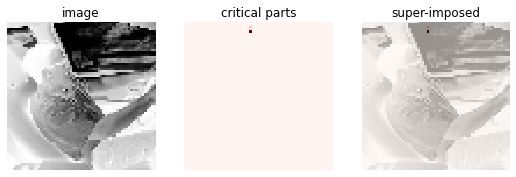

  display_weight:


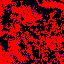

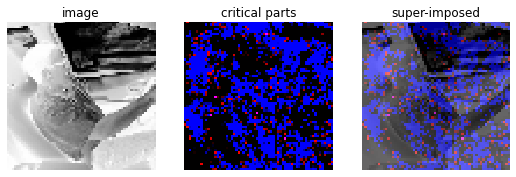

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
min Pby for cls: c8; desc: hair and makeup; proba: 0.5134; nObs: 1
  img_63085.jpg:
  plot_occlusion:


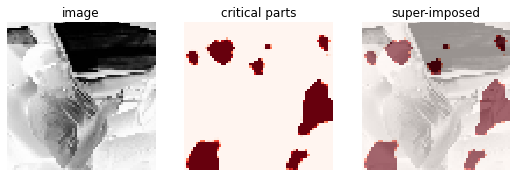

  display_weight:


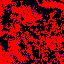

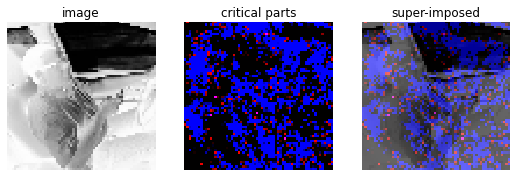

  Proba:
[ 0.      0.      0.4866  0.      0.      0.      0.      0.      0.5134
  0.    ]
  next best class: talking on the phone - right


max Pby for cls: c9; desc: talking to passenger; proba: 1.0000; nObs: 91
  img_25562.jpg:
  plot_occlusion:


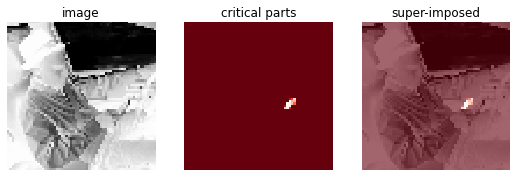

  display_weight:


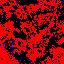

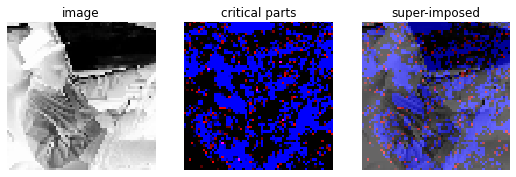

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
min Pby for cls: c9; desc: talking to passenger; proba: 0.5606; nObs: 1
  img_61126.jpg:
  plot_occlusion:


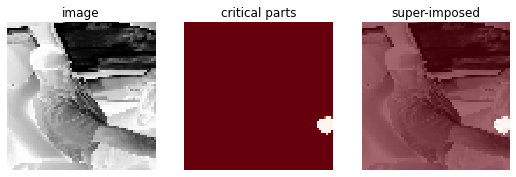

  display_weight:


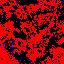

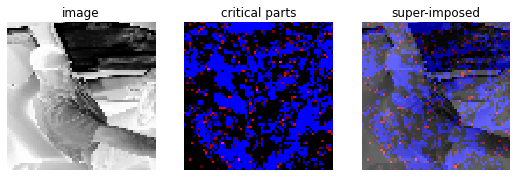

  Proba:
[ 0.4394  0.      0.      0.      0.      0.      0.      0.      0.
  0.5606]
  next best class: normal driving
  predicting 79726 new obs...


max Pby for cls: c0; desc: normal driving; proba: 1.0000; nObs: 9879
  img_100.jpg:
  plot_occlusion:


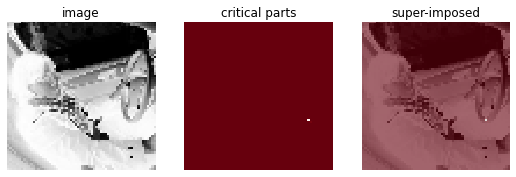

  display_weight:


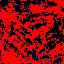

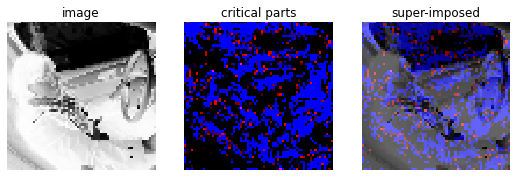

  Proba:
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c0; desc: normal driving; proba: 0.4028; nObs: 1
  img_19394.jpg:
  plot_occlusion:


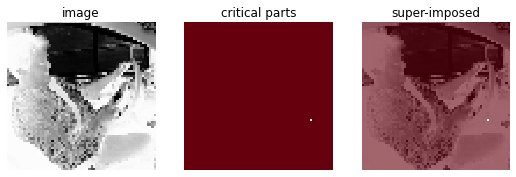

  display_weight:


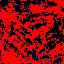

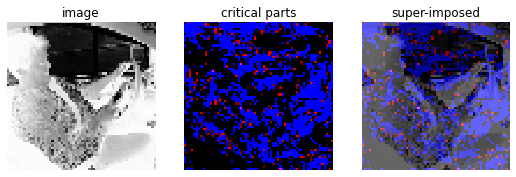

  Proba:
[ 0.4028  0.      0.      0.367   0.      0.      0.      0.      0.
  0.2302]
  next best class: texting - left


max Pby for cls: c1; desc: texting - right; proba: 1.0000; nObs: 2864
  img_100030.jpg:
  plot_occlusion:


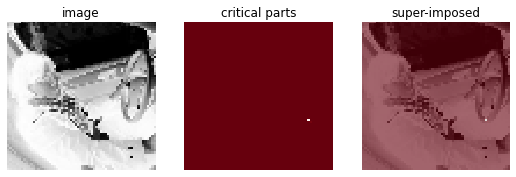

  display_weight:


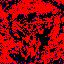

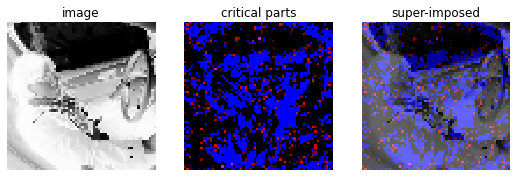

  Proba:
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c1; desc: texting - right; proba: 0.5020; nObs: 1
  img_47748.jpg:
  plot_occlusion:


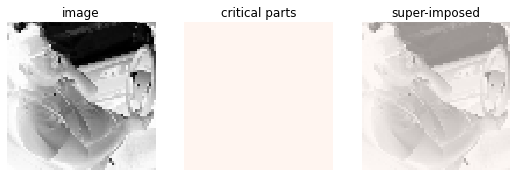

  display_weight:


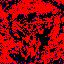

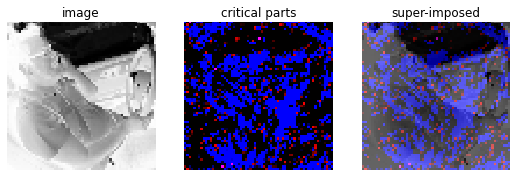

  Proba:
[ 0.     0.502  0.     0.498  0.     0.     0.     0.     0.     0.   ]
  next best class: texting - left


max Pby for cls: c2; desc: talking on the phone - right; proba: 1.0000; nObs: 11332
  img_1.jpg:
  plot_occlusion:


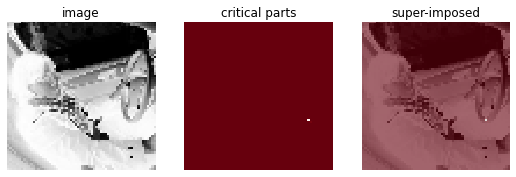

  display_weight:


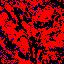

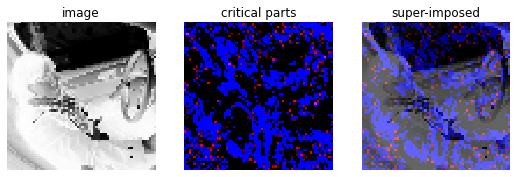

  Proba:
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c2; desc: talking on the phone - right; proba: 0.5030; nObs: 1
  img_8923.jpg:
  plot_occlusion:


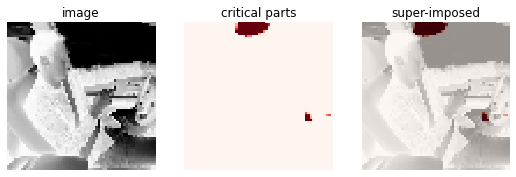

  display_weight:


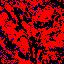

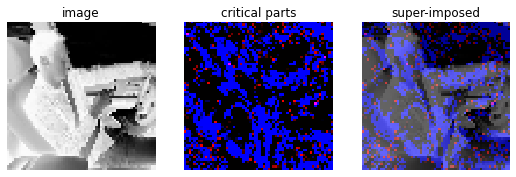

  Proba:
[ 0.     0.     0.503  0.     0.     0.     0.     0.497  0.     0.   ]
  next best class: reaching behind


max Pby for cls: c3; desc: texting - left; proba: 1.0000; nObs: 5611
  img_10.jpg:
  plot_occlusion:


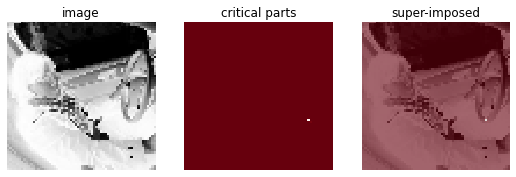

  display_weight:


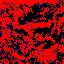

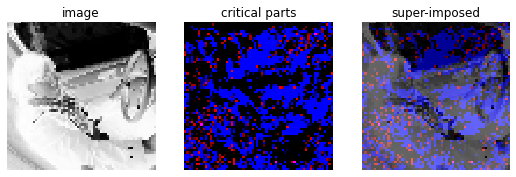

  Proba:
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c3; desc: texting - left; proba: 0.4147; nObs: 1
  img_10687.jpg:
  plot_occlusion:


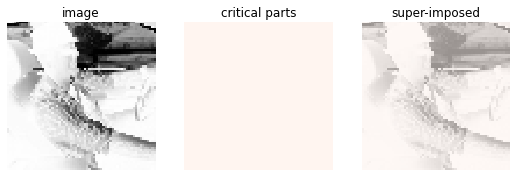

  display_weight:


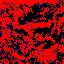

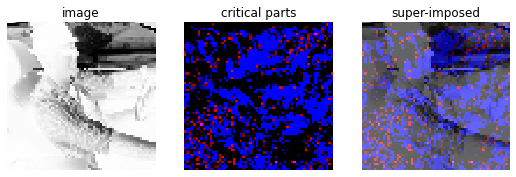

  Proba:
[ 0.2919  0.      0.      0.4147  0.      0.      0.      0.2934  0.      0.    ]
  next best class: reaching behind


max Pby for cls: c4; desc: talking on the phone - left; proba: 1.0000; nObs: 2413
  img_100016.jpg:
  plot_occlusion:


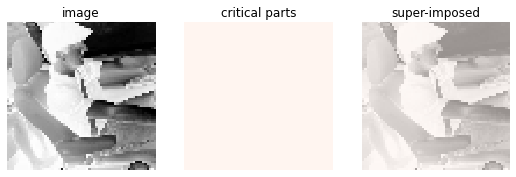

  display_weight:


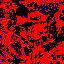

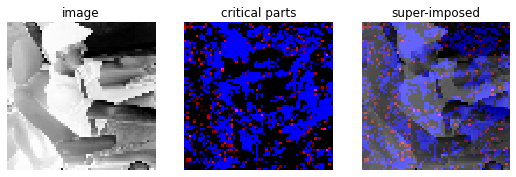

  Proba:
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
min Pby for cls: c4; desc: talking on the phone - left; proba: 0.4235; nObs: 1
  img_73467.jpg:
  plot_occlusion:


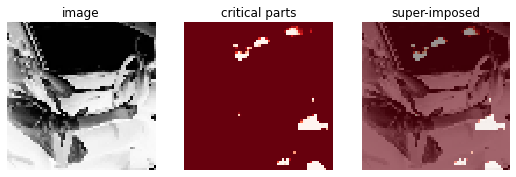

  display_weight:


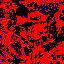

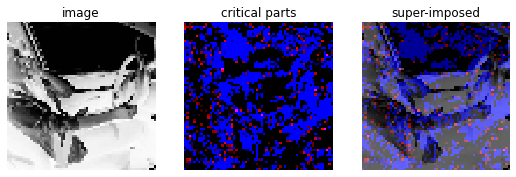

  Proba:
[ 0.      0.      0.      0.2586  0.4235  0.      0.      0.3179  0.      0.    ]
  next best class: reaching behind


max Pby for cls: c5; desc: operating the radio; proba: 1.0000; nObs: 4406
  img_100023.jpg:
  plot_occlusion:


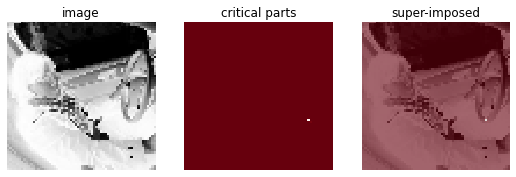

  display_weight:


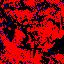

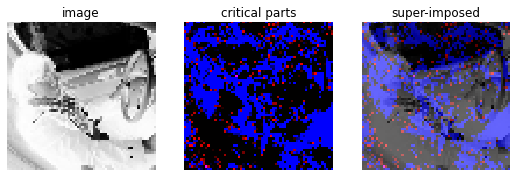

  Proba:
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
min Pby for cls: c5; desc: operating the radio; proba: 0.5054; nObs: 1
  img_38145.jpg:
  plot_occlusion:


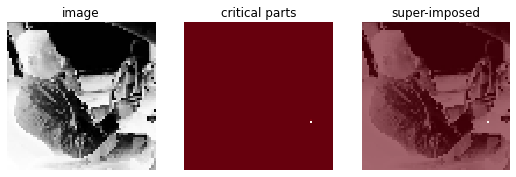

  display_weight:


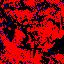

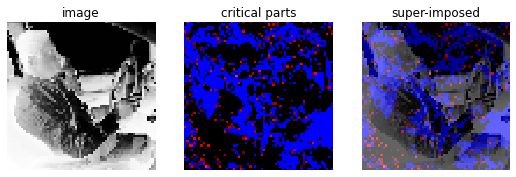

  Proba:
[ 0.4946  0.      0.      0.      0.      0.5054  0.      0.      0.      0.    ]
  next best class: normal driving


max Pby for cls: c6; desc: drinking; proba: 1.0000; nObs: 5603
  img_100004.jpg:
  plot_occlusion:


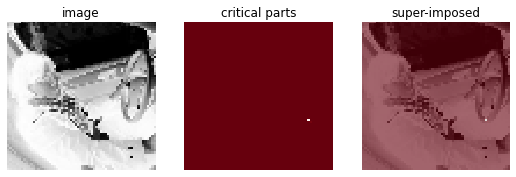

  display_weight:


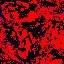

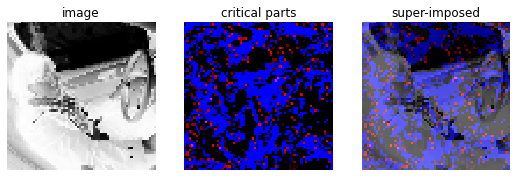

  Proba:
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
min Pby for cls: c6; desc: drinking; proba: 0.5026; nObs: 1
  img_92615.jpg:
  plot_occlusion:


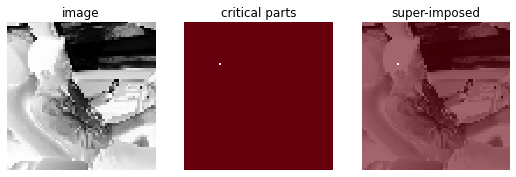

  display_weight:


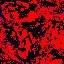

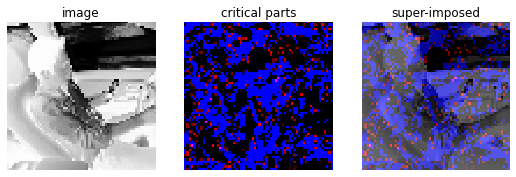

  Proba:
[ 0.      0.      0.      0.      0.      0.      0.5026  0.      0.4974
  0.    ]
  next best class: hair and makeup


max Pby for cls: c7; desc: reaching behind; proba: 1.0000; nObs: 12661
  img_100005.jpg:
  plot_occlusion:


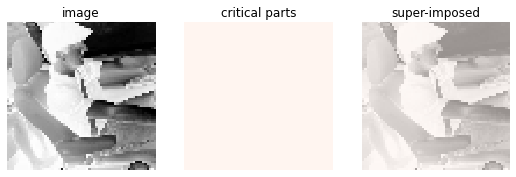

  display_weight:


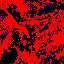

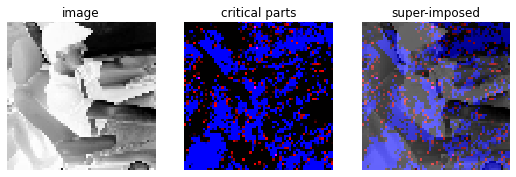

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
min Pby for cls: c7; desc: reaching behind; proba: 0.4289; nObs: 1
  img_32173.jpg:
  plot_occlusion:


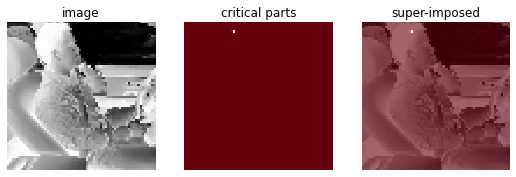

  display_weight:


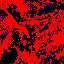

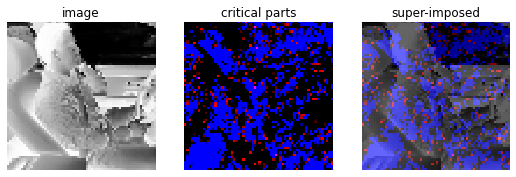

  Proba:
[ 0.      0.      0.2325  0.      0.      0.      0.3386  0.4289  0.      0.    ]
  next best class: drinking


max Pby for cls: c8; desc: hair and makeup; proba: 1.0000; nObs: 5467
  img_100007.jpg:
  plot_occlusion:


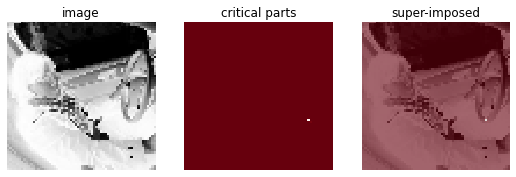

  display_weight:


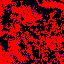

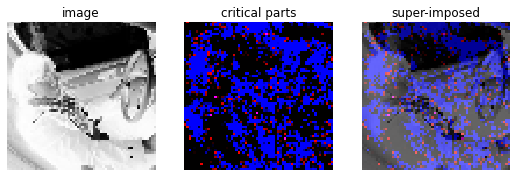

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
min Pby for cls: c8; desc: hair and makeup; proba: 0.4734; nObs: 1
  img_97640.jpg:
  plot_occlusion:


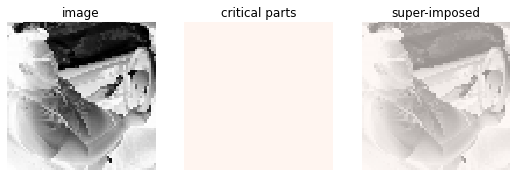

  display_weight:


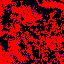

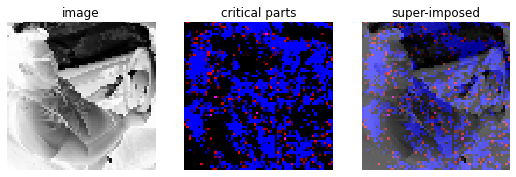

  Proba:
[ 0.      0.1803  0.      0.      0.      0.      0.3463  0.      0.4734
  0.    ]
  next best class: drinking


max Pby for cls: c9; desc: talking to passenger; proba: 1.0000; nObs: 6562
  img_100028.jpg:
  plot_occlusion:


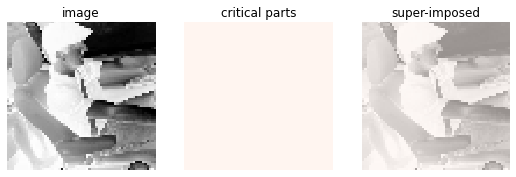

  display_weight:


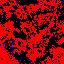

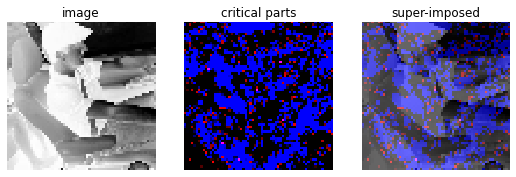

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
min Pby for cls: c9; desc: talking to passenger; proba: 0.4141; nObs: 1
  img_9380.jpg:
  plot_occlusion:


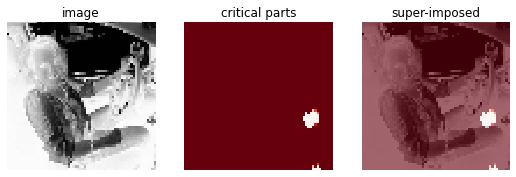

  display_weight:


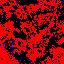

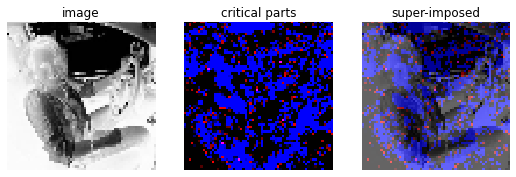

  Proba:
[ 0.2825  0.3034  0.      0.      0.      0.      0.      0.      0.
  0.4141]
  next best class: texting - right

  New prediction knts:
{'kntCls': (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([11609,  3451, 13417,  6688,  3000,  4989,  6714, 14866,  6579,  8413]))}
  duration: 107 seconds


In [15]:
selMdlDf, selYVldPby, selYNewPby = fitMdlLgtRgrSGDTfw(
    glbXFit, glbYFit, 
    nObsFit = glbXFit.shape[0], 
    nObsBtc = selMdlSrs['nObsBtc'][0],     
    rotatePby = selMdlSrs['rotatePby'][0],     
    rotateMaxAgl = selMdlSrs['rotateMaxAgl'][0],         
    nStepsTfw = selMdlSrs['nStepsTfw'][0], 
    lrnRateTfw = selMdlSrs['lrnRateTfw'][0], 
    visualize = True, newObs = True, verbose = True)
# def fitMdlLgtRgrSGDTfw(lclXFit, lclYFit, 
#             nObsFit = 100, nObsBtc = 16, 
#             rotatePby = 0.1, rotateMaxAgl = 5,
#             nStepsTfw = 10, lrnRateTfw = 0.1,
#                     visualize = False, newObs = False, verbose = False):

In [16]:
print '\n selMdl:'
glbwriteSubmission(glbINew, selYNewPby, 
    'img_04_fit_lgtRgr_SGD_Tfw_SFDD_ImgSz_' + str(glbImg['size']) + \
                   '_sbmt_sel.csv')


 selMdl:
                           img            c0   c1   c2   c3            c4  \
img                                                                         
img_1.jpg            img_1.jpg  6.764812e-32  0.0  1.0  0.0  3.422848e-29   
img_10.jpg          img_10.jpg  0.000000e+00  0.0  0.0  1.0  0.000000e+00   
img_100.jpg        img_100.jpg  1.000000e+00  0.0  0.0  0.0  0.000000e+00   
img_1000.jpg      img_1000.jpg  2.215907e-07  0.0  0.0  0.0  8.074588e-30   
img_100000.jpg  img_100000.jpg  0.000000e+00  0.0  0.0  1.0  9.966320e-19   

                          c5            c6            c7   c8   c9  
img                                                                 
img_1.jpg       0.000000e+00  0.000000e+00  3.077862e-11  0.0  0.0  
img_10.jpg      8.291059e-29  0.000000e+00  0.000000e+00  0.0  0.0  
img_100.jpg     0.000000e+00  0.000000e+00  0.000000e+00  0.0  0.0  
img_1000.jpg    0.000000e+00  5.287736e-14  0.000000e+00  0.0  1.0  
img_100000.jpg  0.000000e+00  0.0000

### Fit selected model to glbObsTrn


Logistic Regression (TensorFlow): nObsFit:22424; nObsBtc:    8; rotatePby: 0.1000; rotateMaxAgl:   2; nStepsTfw: 2804; lrnRateTfw:3.0000 
  visualize: True; newObs: True; verbose: True
('  tfwW:', <tf.Tensor 'Identity:0' shape=(4096, 10) dtype=float32>)
('  tfwB:', <tf.Tensor 'Identity_1:0' shape=(10,) dtype=float32>)
  Initialized

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:124: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:143: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:126: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



  step     1(    0 secs): Minibatch rotation:angle: 0.7815
  step     6(    0 secs): Minibatch rotation:angle: 1.3900
  step    13(    0 secs): Minibatch rotation:angle: 1.4487
  step    34(    0 secs): Minibatch rotation:angle: 0.2647
  step    39(    0 secs): Minibatch rotation:angle: -0.4238
  step    40(    0 secs): Minibatch rotation:angle: -1.0228
  step    42(    0 secs): Minibatch rotation:angle: -1.5997
  step    73(    1 secs): Minibatch rotation:angle: -1.4536
  step    75(    1 secs): Minibatch rotation:angle: 0.7455
  step    78(    1 secs): Minibatch rotation:angle: -0.2561
  step    86(    1 secs): Minibatch rotation:angle: 0.0559
  step    89(    1 secs): Minibatch rotation:angle: 0.8329
  step    93(    1 secs): Minibatch rotation:angle: 0.1879
  step   101(    1 secs): Minibatch rotation:angle: 0.1547
  step   123(    1 secs): Minibatch rotation:angle: 0.4447
  step   134(    1 secs): Minibatch rotation:angle: -1.7246
  step   139(    1 secs): Minibatch rotation:angl

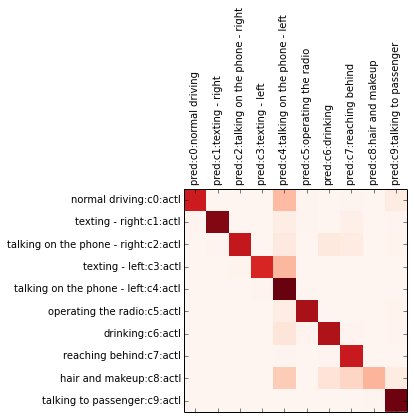


  Vld  logLoss:4.8369
[ 0.9739  0.2233  0.6196  0.6802  0.      0.1763  0.3445  0.0209  1.7902
  0.008 ]


max Pby for cls: c0; desc: normal driving; proba: 1.0000; nObs: 320
  img_62023.jpg:
  plot_occlusion:


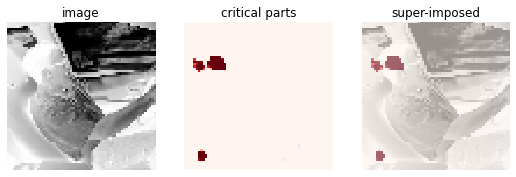

  display_weight:


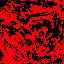

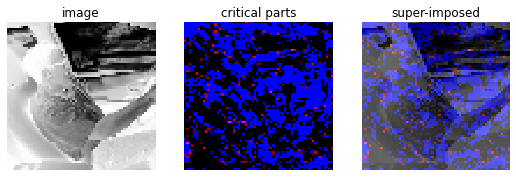

  Proba:
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c0; desc: normal driving; proba: 0.6795; nObs: 1
  img_80584.jpg:
  plot_occlusion:


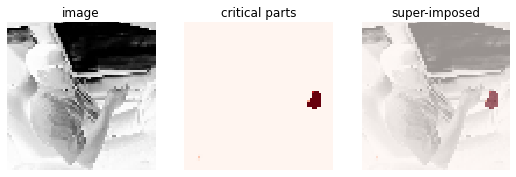

  display_weight:


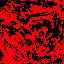

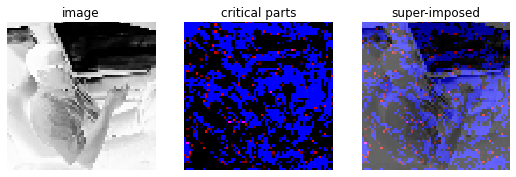

  Proba:
[ 0.6795  0.      0.      0.      0.      0.      0.      0.      0.
  0.3205]
  next best class: talking to passenger


max Pby for cls: c1; desc: texting - right; proba: 1.0000; nObs: 426
  img_89322.jpg:
  plot_occlusion:


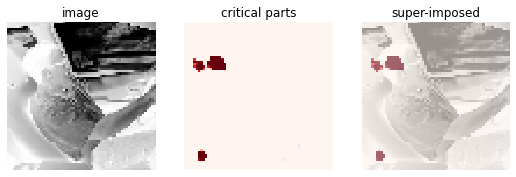

  display_weight:


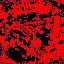

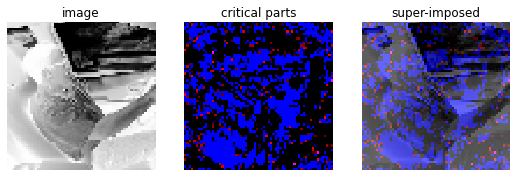

  Proba:
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c1; desc: texting - right; proba: 0.8060; nObs: 1
  img_83254.jpg:
  plot_occlusion:


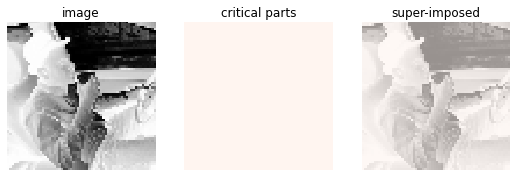

  display_weight:


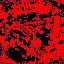

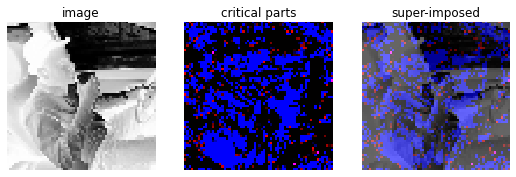

  Proba:
[ 0.     0.806  0.     0.     0.     0.194  0.     0.     0.     0.   ]
  next best class: operating the radio


max Pby for cls: c2; desc: talking on the phone - right; proba: 1.0000; nObs: 342
  img_87211.jpg:
  plot_occlusion:


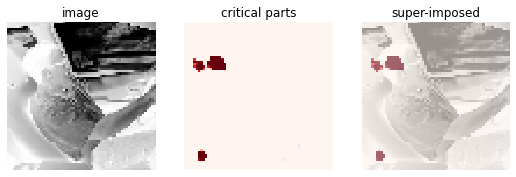

  display_weight:


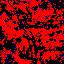

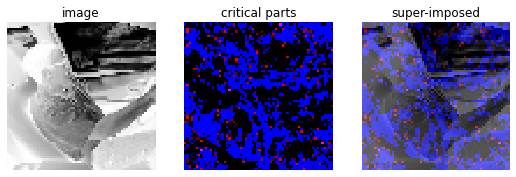

  Proba:
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c2; desc: talking on the phone - right; proba: 0.6004; nObs: 1
  img_53195.jpg:
  plot_occlusion:


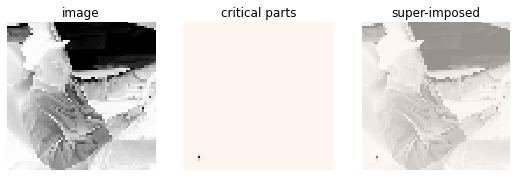

  display_weight:


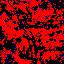

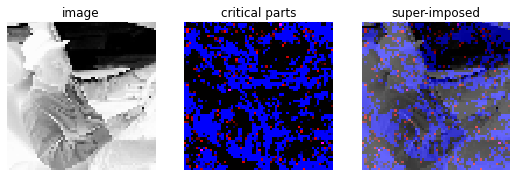

  Proba:
[ 0.      0.      0.6004  0.      0.3996  0.      0.      0.      0.      0.    ]
  next best class: talking on the phone - left


max Pby for cls: c3; desc: texting - left; proba: 1.0000; nObs: 288
  img_77361.jpg:
  plot_occlusion:


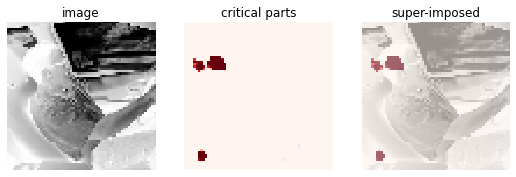

  display_weight:


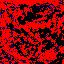

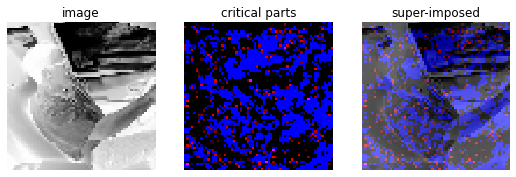

  Proba:
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c3; desc: texting - left; proba: 0.5175; nObs: 1
  img_94042.jpg:
  plot_occlusion:


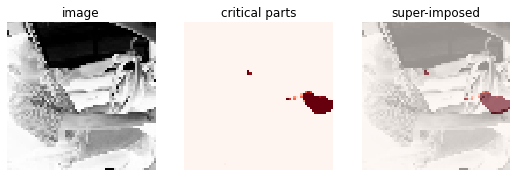

  display_weight:


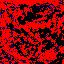

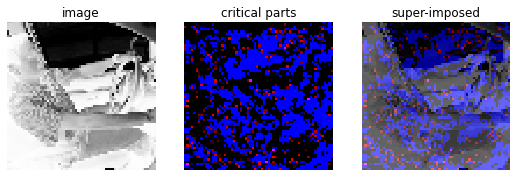

  Proba:
[ 0.      0.      0.      0.5175  0.4825  0.      0.      0.      0.      0.    ]
  next best class: talking on the phone - left


max Pby for cls: c4; desc: talking on the phone - left; proba: 1.0000; nObs: 807
  img_78749.jpg:
  plot_occlusion:


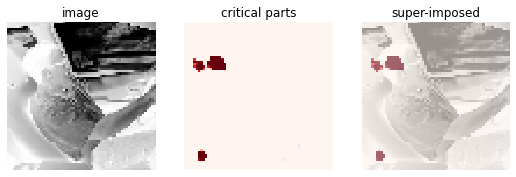

  display_weight:


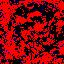

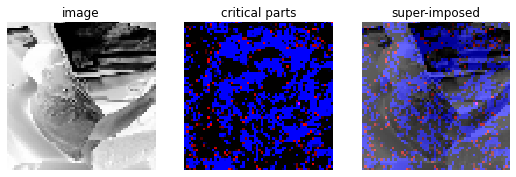

  Proba:
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
min Pby for cls: c4; desc: talking on the phone - left; proba: 0.5045; nObs: 1
  img_12442.jpg:
  plot_occlusion:


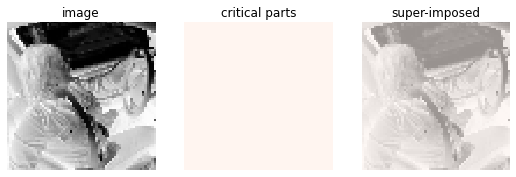

  display_weight:


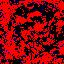

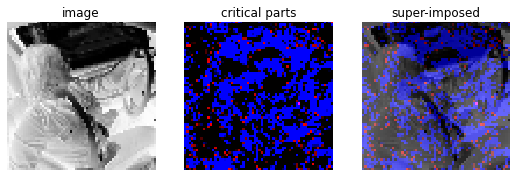

  Proba:
[ 0.      0.      0.      0.4955  0.5045  0.      0.      0.      0.      0.    ]
  next best class: texting - left


max Pby for cls: c5; desc: operating the radio; proba: 1.0000; nObs: 398
  img_70461.jpg:
  plot_occlusion:


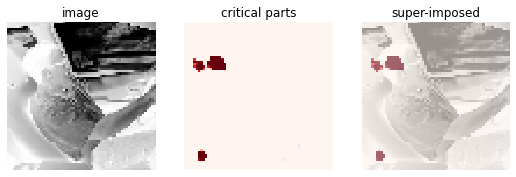

  display_weight:


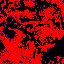

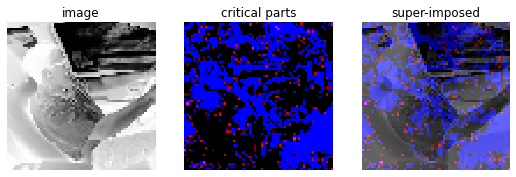

  Proba:
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
min Pby for cls: c5; desc: operating the radio; proba: 0.8562; nObs: 1
  img_54029.jpg:
  plot_occlusion:


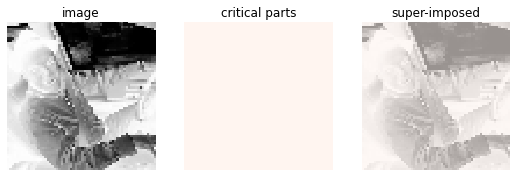

  display_weight:


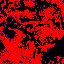

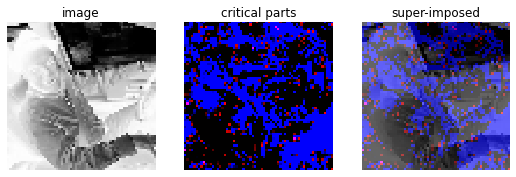

  Proba:
[ 0.      0.1438  0.      0.      0.      0.8562  0.      0.      0.      0.    ]
  next best class: texting - right


max Pby for cls: c6; desc: drinking; proba: 1.0000; nObs: 440
  img_68722.jpg:
  plot_occlusion:


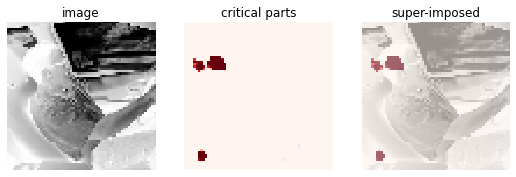

  display_weight:


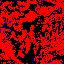

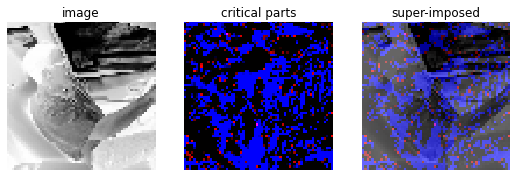

  Proba:
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
min Pby for cls: c6; desc: drinking; proba: 0.7608; nObs: 1
  img_32199.jpg:
  plot_occlusion:


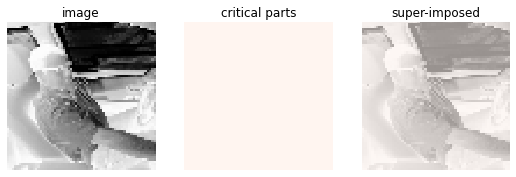

  display_weight:


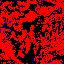

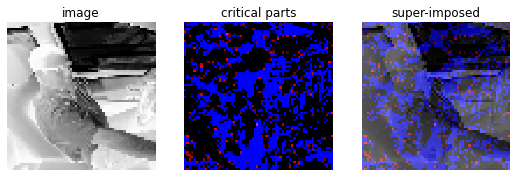

  Proba:
[ 0.      0.      0.      0.      0.2392  0.      0.7608  0.      0.      0.    ]
  next best class: talking on the phone - left


max Pby for cls: c7; desc: reaching behind; proba: 1.0000; nObs: 433
  img_29251.jpg:
  plot_occlusion:


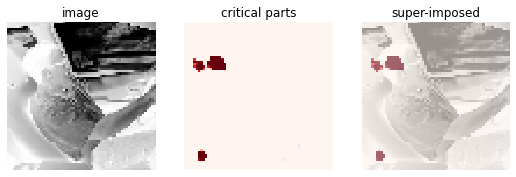

  display_weight:


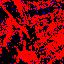

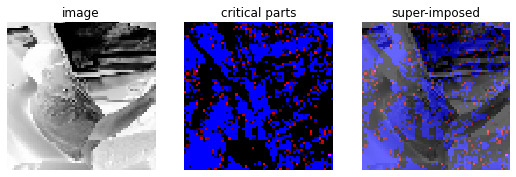

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
min Pby for cls: c7; desc: reaching behind; proba: 0.4930; nObs: 1
  img_88262.jpg:
  plot_occlusion:


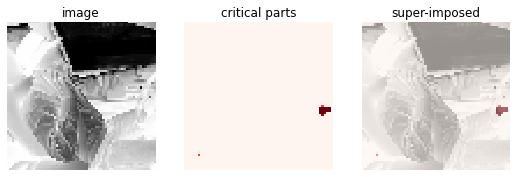

  display_weight:


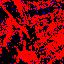

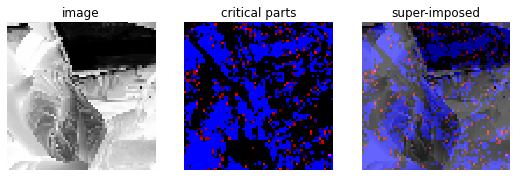

  Proba:
[ 0.      0.      0.0498  0.      0.      0.      0.4572  0.493   0.      0.    ]
  next best class: drinking


max Pby for cls: c8; desc: hair and makeup; proba: 1.0000; nObs: 107
  img_8759.jpg:
  plot_occlusion:


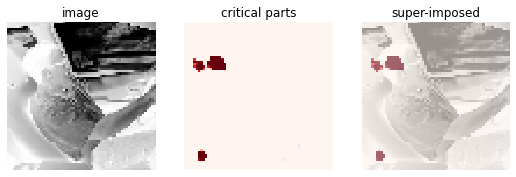

  display_weight:


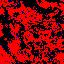

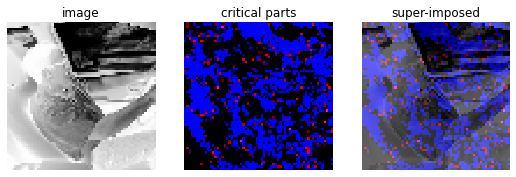

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
min Pby for cls: c8; desc: hair and makeup; proba: 0.8165; nObs: 1
  img_9578.jpg:
  plot_occlusion:


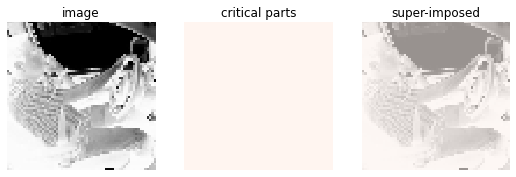

  display_weight:


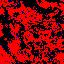

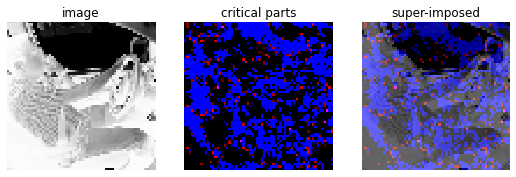

  Proba:
[ 0.      0.      0.      0.      0.1835  0.      0.      0.      0.8165
  0.    ]
  next best class: talking on the phone - left


max Pby for cls: c9; desc: talking to passenger; proba: 1.0000; nObs: 497
  img_24934.jpg:
  plot_occlusion:


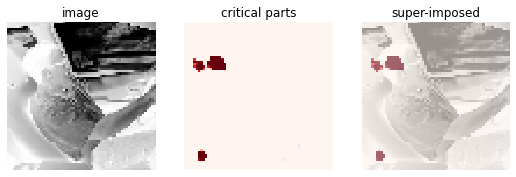

  display_weight:


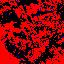

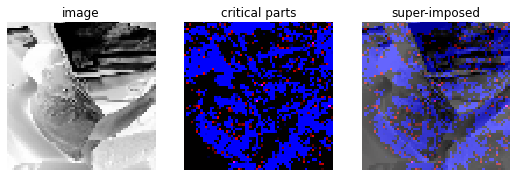

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
min Pby for cls: c9; desc: talking to passenger; proba: 0.8207; nObs: 1
  img_60533.jpg:
  plot_occlusion:


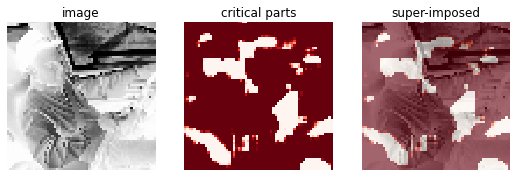

  display_weight:


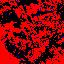

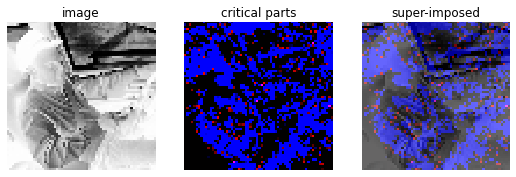

  Proba:
[ 0.      0.      0.      0.      0.1793  0.      0.      0.      0.
  0.8207]
  next best class: talking on the phone - left
  predicting 79726 new obs...
    @   68 secs: obsIx:     0
    @   69 secs: obsIx:  8000
    @   74 secs: obsIx: 40000


max Pby for cls: c0; desc: normal driving; proba: 1.0000; nObs: 3083
  img_100.jpg:
  plot_occlusion:


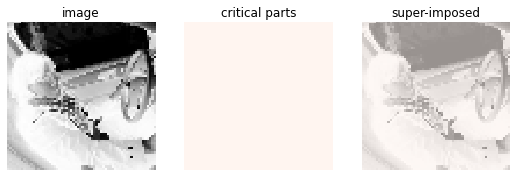

  display_weight:


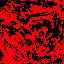

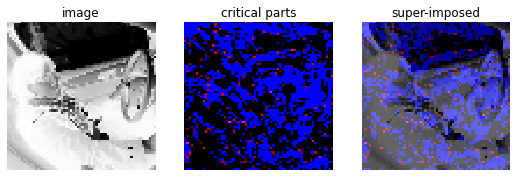

  Proba:
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c0; desc: normal driving; proba: 0.5038; nObs: 1
  img_91731.jpg:
  plot_occlusion:


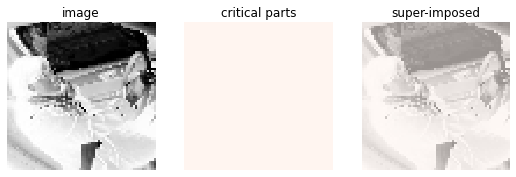

  display_weight:


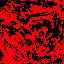

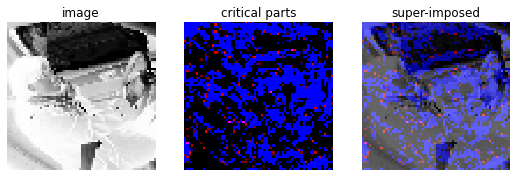

  Proba:
[ 0.5038  0.      0.      0.      0.4962  0.      0.      0.      0.      0.    ]
  next best class: talking on the phone - left


max Pby for cls: c1; desc: texting - right; proba: 1.0000; nObs: 3904
  img_100003.jpg:
  plot_occlusion:


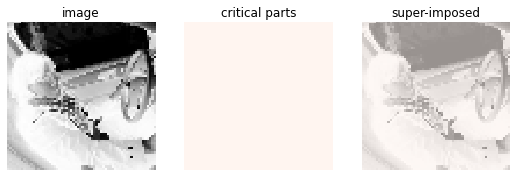

  display_weight:


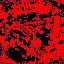

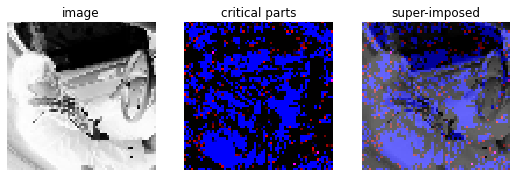

  Proba:
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c1; desc: texting - right; proba: 0.4488; nObs: 1
  img_58091.jpg:
  plot_occlusion:


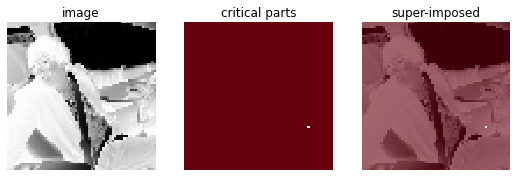

  display_weight:


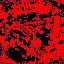

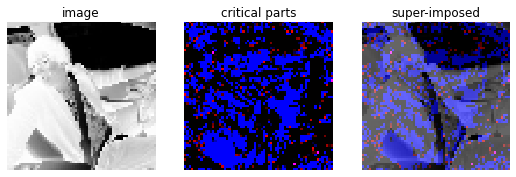

  Proba:
[ 0.      0.4488  0.      0.      0.2213  0.      0.      0.      0.
  0.3298]
  next best class: talking to passenger


max Pby for cls: c2; desc: talking on the phone - right; proba: 1.0000; nObs: 1733
  img_10001.jpg:
  plot_occlusion:


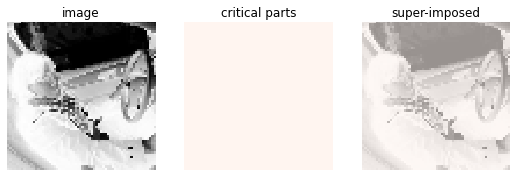

  display_weight:


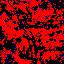

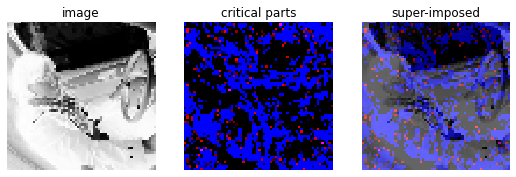

  Proba:
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c2; desc: talking on the phone - right; proba: 0.5096; nObs: 1
  img_57784.jpg:
  plot_occlusion:


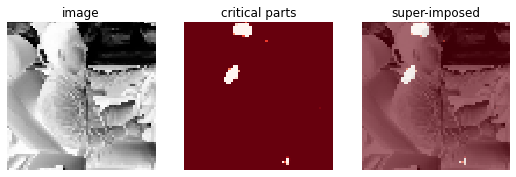

  display_weight:


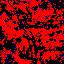

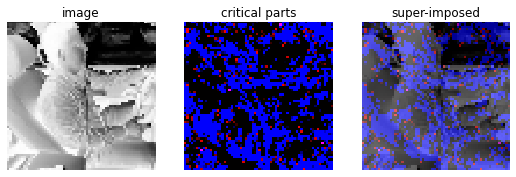

  Proba:
[ 0.      0.      0.5096  0.      0.      0.      0.      0.      0.
  0.4904]
  next best class: talking to passenger


max Pby for cls: c3; desc: texting - left; proba: 1.0000; nObs: 3918
  img_10.jpg:
  plot_occlusion:


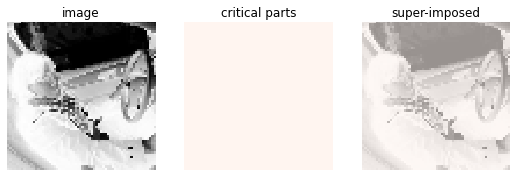

  display_weight:


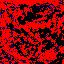

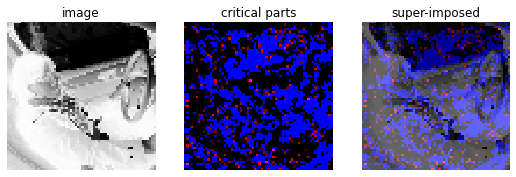

  Proba:
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
min Pby for cls: c3; desc: texting - left; proba: 0.5045; nObs: 1
  img_78739.jpg:
  plot_occlusion:


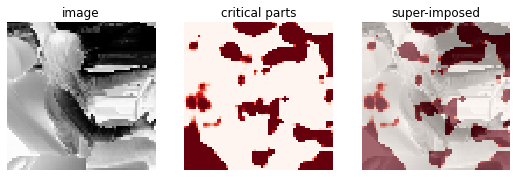

  display_weight:


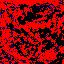

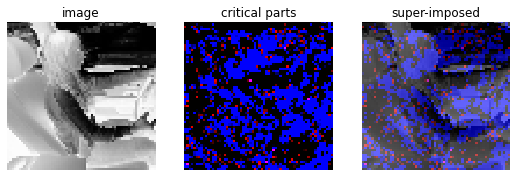

  Proba:
[ 0.      0.      0.      0.5045  0.0001  0.      0.      0.      0.
  0.4955]
  next best class: talking to passenger


max Pby for cls: c4; desc: talking on the phone - left; proba: 1.0000; nObs: 24812
  img_1000.jpg:
  plot_occlusion:


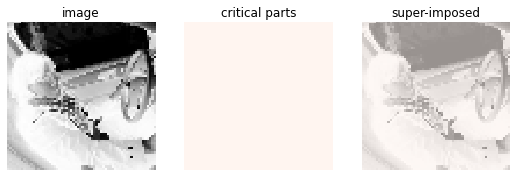

  display_weight:


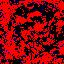

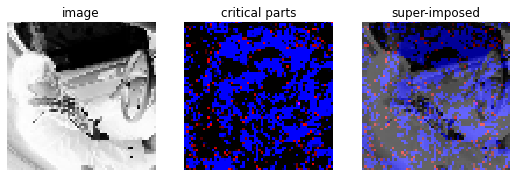

  Proba:
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
min Pby for cls: c4; desc: talking on the phone - left; proba: 0.4816; nObs: 1
  img_68076.jpg:
  plot_occlusion:


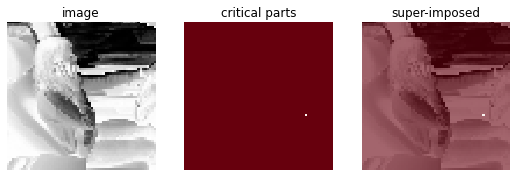

  display_weight:


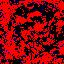

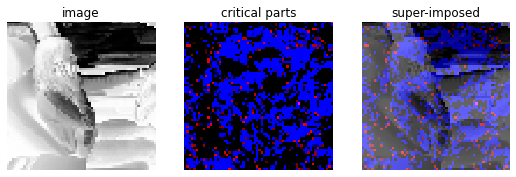

  Proba:
[ 0.      0.      0.      0.4636  0.4816  0.      0.      0.      0.
  0.0547]
  next best class: texting - left


max Pby for cls: c5; desc: operating the radio; proba: 1.0000; nObs: 5699
  img_100001.jpg:
  plot_occlusion:


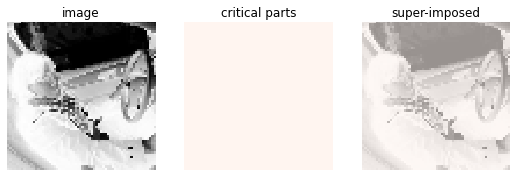

  display_weight:


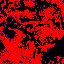

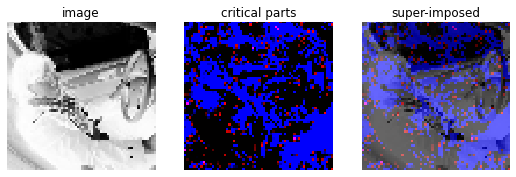

  Proba:
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
min Pby for cls: c5; desc: operating the radio; proba: 0.3664; nObs: 1
  img_78625.jpg:
  plot_occlusion:


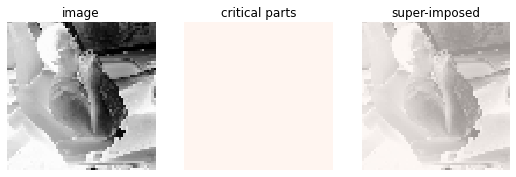

  display_weight:


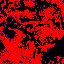

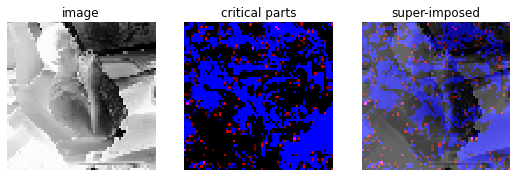

  Proba:
[ 0.2851  0.      0.      0.      0.3485  0.3664  0.      0.      0.      0.    ]
  next best class: talking on the phone - left


max Pby for cls: c6; desc: drinking; proba: 1.0000; nObs: 5312
  img_100004.jpg:
  plot_occlusion:


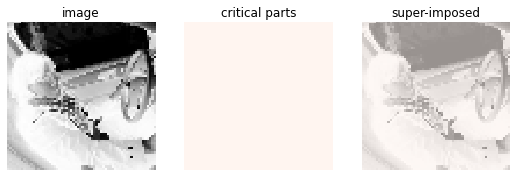

  display_weight:


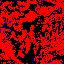

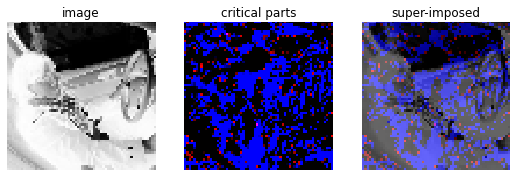

  Proba:
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
min Pby for cls: c6; desc: drinking; proba: 0.5082; nObs: 1
  img_48373.jpg:
  plot_occlusion:


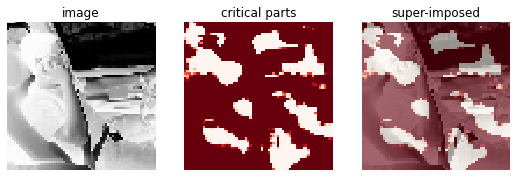

  display_weight:


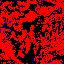

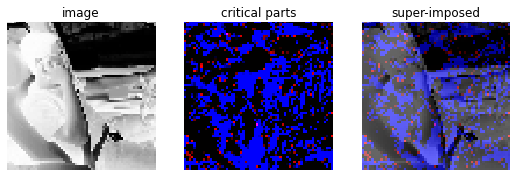

  Proba:
[ 0.      0.      0.      0.      0.4918  0.      0.5082  0.      0.      0.    ]
  next best class: talking on the phone - left


max Pby for cls: c7; desc: reaching behind; proba: 1.0000; nObs: 6124
  img_100005.jpg:
  plot_occlusion:


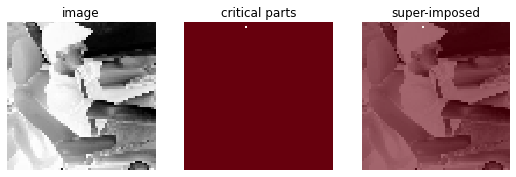

  display_weight:


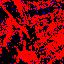

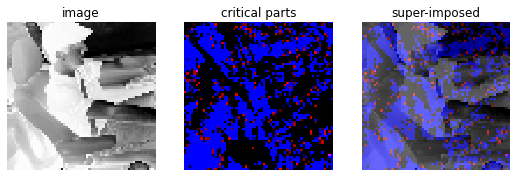

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
min Pby for cls: c7; desc: reaching behind; proba: 0.5014; nObs: 1
  img_22445.jpg:
  plot_occlusion:


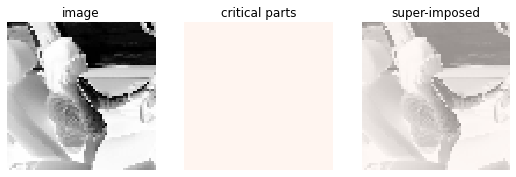

  display_weight:


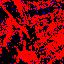

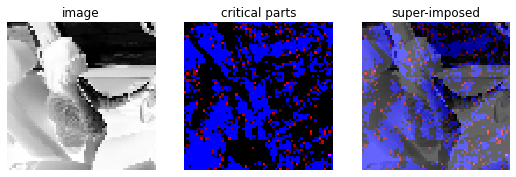

  Proba:
[ 0.      0.      0.      0.      0.4986  0.      0.      0.5014  0.      0.    ]
  next best class: talking on the phone - left


max Pby for cls: c8; desc: hair and makeup; proba: 1.0000; nObs: 4040
  img_100035.jpg:
  plot_occlusion:


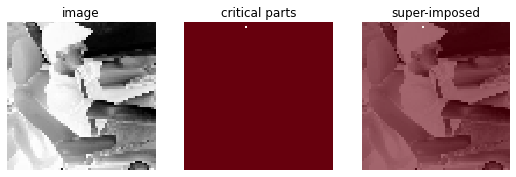

  display_weight:


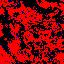

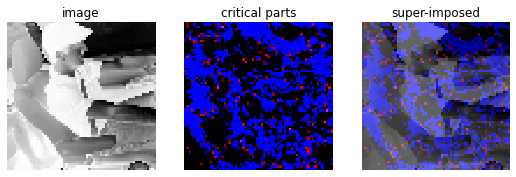

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
min Pby for cls: c8; desc: hair and makeup; proba: 0.5028; nObs: 1
  img_70747.jpg:
  plot_occlusion:


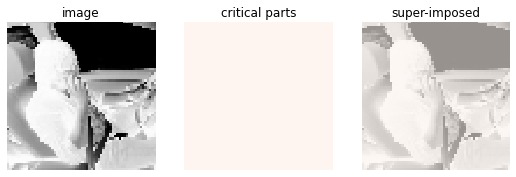

  display_weight:


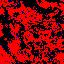

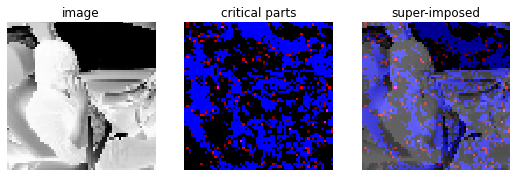

  Proba:
[ 0.      0.      0.      0.      0.      0.      0.      0.      0.5028
  0.4972]
  next best class: talking to passenger


max Pby for cls: c9; desc: talking to passenger; proba: 1.0000; nObs: 11551
  img_100024.jpg:
  plot_occlusion:


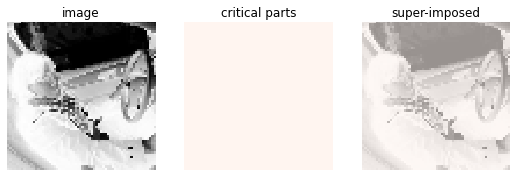

  display_weight:


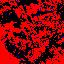

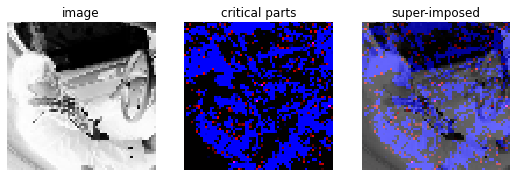

  Proba:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
min Pby for cls: c9; desc: talking to passenger; proba: 0.4451; nObs: 1
  img_89849.jpg:
  plot_occlusion:


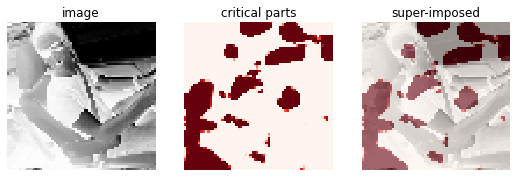

  display_weight:


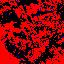

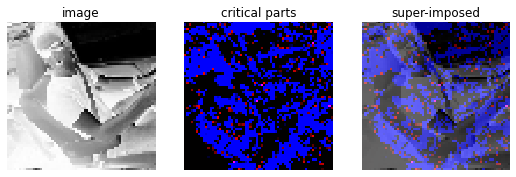

  Proba:
[ 0.      0.      0.2253  0.      0.      0.      0.      0.3296  0.
  0.4451]
  next best class: reaching behind

  New prediction knts:
{'kntCls': (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 3619,  4408,  2109,  4576, 27385,  6501,  6198,  6814,  4881, 13235]))}
  duration: 122 seconds


In [24]:
finMdlDf, finYVldPby, finYNewPby = fitMdlLgtRgrSGDTfw(
    glbXTrn, glbYTrn, 
    nObsFit = glbXTrn.shape[0], 
    nObsBtc = selMdlSrs['nObsBtc'][0],     
    rotatePby = selMdlSrs['rotatePby'][0],     
    rotateMaxAgl = selMdlSrs['rotateMaxAgl'][0],         
    # Ensure all Trn obs are used at least once
    nStepsTfw = max(selMdlSrs['nStepsTfw'][0], 
        glbXTrn.shape[0] * 1.0 / selMdlSrs['nObsBtc'][0] + 1), 
    lrnRateTfw = selMdlSrs['lrnRateTfw'][0],     
    visualize = True, newObs = True, verbose = True)

# selMdlDf, selYVldPby, selYNewPby = fitMdlLgtRgrSGDTfw(
#     glbXFit, glbYFit, 
#     nObsFit = glbXFit.shape[0], 
#     nObsBtc = selMdlSrs['nObsBtc'][0],     
#     rotatePby = selMdlSrs['rotatePby'][0],     
#     rotateMaxAgl = selMdlSrs['rotateMaxAgl'][0],         
#     nStepsTfw = selMdlSrs['nStepsTfw'][0], 
#     lrnRateTfw = selMdlSrs['lrnRateTfw'][0], 
#     visualize = True, newObs = True, verbose = True)

In [25]:
print finMdlDf

               id  lrnRateTfw  nObsBtc  nObsFit  nStepsTfw  rotateMaxAgl  \
0  LgtRgr.SGD.tfw         3.0      8.0    22424     2804.0             2   

   rotatePby    accVld                                          accVldCls  \
0        0.1  0.833218  {u'accCls': [0.704545454545, 0.910041841004, 0...   

   logLossVld                                      logLossVldCls  \
0    4.836929  {u'logLossCls': [0.973879753517, 0.22334474905...   

                                             predNew  \
0  {u'kntCls': ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [...   

                                               model  duration  
0  <tensorflow.python.client.session.Session obje...       122  


In [26]:
glbMdlDf = glbMdlDf.append(finMdlDf)
glbMdlDf = glbMdlDf.set_index(['id'] + srchParamsDct.keys(), drop = False)
glbMdlDf = glbMdlDf.sort_values(
                ['nObsFit', 'accVld', 'logLossVld', 'duration'], 
    ascending = [False    , True    , False,        False])
print(glbMdlDf[list(set(glbMdlDf.columns) - 
                    set(['id'] + srchParamsDct.keys()))])

                                                                                                                    accVldCls  \
id             nStepsTfw nObsFit rotatePby nObsBtc lrnRateTfw rotateMaxAgl                                                      
LgtRgr.SGD.tfw  2804.0   22424.0 0.1       8.0      3.0       2             {u'accCls': [0.704545454545, 0.910041841004, 0...   
LgtRgr.tfw      1000.0   22424.0 0.0       22424.0  10.0      0             {u'accCls': [0.989669421488, 0.991631799163, 0...   
LgtRgr.skl     -1.0      22424.0 0.0       22424.0 -1.0       0                                                           NaN   
LgtRgr.SGD.tfw  1000.0   18077.0 0.5       4.0      3.0       10            {u'accCls': [0.297520661157, 0.081589958159, 0...   
                100.0    18077.0 0.1       16.0     1.0       10            {u'accCls': [0.0, 0.150627615063, 0.0, 0.00225...   
                1000.0   18077.0 0.0       16.0     2.0       10            {u'accCls': [0.495867

In [27]:
myexportDf(glbMdlDf, 
           save_filepathname = glbPickleFile['models'],
           save_drop_cols = 'model'
          )

Compressed pickle file: data/img_M_SFDD_ImgSz_64.pickle; size: 41 KB


## Output submission

In [28]:
print '\n finMdl:'
glbwriteSubmission(glbINew, finYNewPby, 
    'img_04_fit_lgtRgr_SGD_Tfw_SFDD_ImgSz_' + str(glbImg['size']) + \
                   '_sbmt_fin.csv')


 finMdl:
                           img   c0   c1   c2   c3            c4   c5  \
img                                                                     
img_1.jpg            img_1.jpg  0.0  0.0  0.0  0.0  7.011857e-02  0.0   
img_10.jpg          img_10.jpg  0.0  0.0  0.0  1.0  0.000000e+00  0.0   
img_100.jpg        img_100.jpg  1.0  0.0  0.0  0.0  1.445693e-27  0.0   
img_1000.jpg      img_1000.jpg  0.0  0.0  0.0  0.0  1.000000e+00  0.0   
img_100000.jpg  img_100000.jpg  0.0  0.0  0.0  0.0  1.000000e+00  0.0   

                          c6        c7   c8   c9  
img                                               
img_1.jpg       0.000000e+00  0.929881  0.0  0.0  
img_10.jpg      0.000000e+00  0.000000  0.0  0.0  
img_100.jpg     0.000000e+00  0.000000  0.0  0.0  
img_1000.jpg    6.692277e-32  0.000000  0.0  0.0  
img_100000.jpg  0.000000e+00  0.000000  0.0  0.0  
                         img   c0   c1   c2   c3   c4   c5   c6   c7   c8   c9
img                                       

In [29]:
prtStr = 'LeaderBoard metric for this sel submission: %0.5f vs. ' + \
        'logLossVld (sel): %0.5f'
print prtStr % (22.62562, 20.5467)
prtStr = 'LeaderBoard metric for this fin submission: %0.5f vs. ' + \
        'logLossVld (fin): %0.5f'
print prtStr % (23.71528,  4.8369)
print 'Best score yet:%s: %0.5f' % \
    ('img_02_fit_lgtRgr(Skl)_SFDD_(ImgSz_32_)sbmt(_fin).csv', 2.63892)

LeaderBoard metric for this sel submission: 22.62562 vs. logLossVld (sel): 20.54670
LeaderBoard metric for this fin submission: 23.71528 vs. logLossVld (fin): 4.83690
Best score yet:img_02_fit_lgtRgr(Skl)_SFDD_(ImgSz_32_)sbmt(_fin).csv: 2.63892


## Stop here

Following code should be in img_04_fit_lgtRgrSGDTf_<projectId>

Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `sesion.run()`.

In [6]:
import pandas as pd
models = pd.DataFrame({'nRELUs': [0]})
#models.ix[0, 'accuracy_scoreTest'] = 0
print models

   nRELUs
0       0


In [7]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tfwObsFitFtr = tf.placeholder(tf.float32,
                                    shape=(batch_size, glbImg['size'] * glbImg['size']))
  tfwObsFitRsp = tf.placeholder(tf.float32, shape=(batch_size, glbRspClassN))
  tfwObsVldFtr = tf.constant(glbXVld)
  tfwObsNewFtr = tf.constant(glbXNew)
  
  # Variables.
  tfwW = tf.Variable(
    tf.truncated_normal([glbImg['size'] * glbImg['size'], glbRspClassN]))
  tfwB = tf.Variable(tf.zeros([glbRspClassN]))
  print(tfwW.initialized_value())
  print(tfwB.initialized_value())    
  
  # Training computation.
  logits = tf.matmul(tfwObsFitFtr, tfwW) + tfwB
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tfwObsFitRsp))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  tfwObsTrnPred = tf.nn.softmax(logits)
  tfwObsVldPred = tf.nn.softmax(
    tf.matmul(tfwObsVldFtr, tfwW) + tfwB)
  tfwObsNewPred = tf.nn.softmax(tf.matmul(tfwObsNewFtr, tfwW) + tfwB)

Tensor("Identity:0", shape=TensorShape([Dimension(784), Dimension(10)]), dtype=float32)
Tensor("Identity_1:0", shape=TensorShape([Dimension(10)]), dtype=float32)


Let's run it:

In [8]:
nStepsTfw = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(nStepsTfw):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (glbYFit.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = glbXFit[offset:(offset + batch_size), :]
    batch_labels = glbYFit[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tfwObsFitFtr : batch_data, tfwObsFitRsp : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, tfwObsTrnPred], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy_score: %.1f%%" % accuracy_score(predictions, batch_labels))
      print("Validation accuracy_score: %.1f%%" % accuracy_score(
        tfwObsVldPred.eval(), glbYVld))
  print("Test accuracy_score: %.1f%%" % accuracy_score(tfwObsNewPred.eval(), glbYNew))
  models.ix[0, 'accuracy_scoreVld'] = accuracy_score(tfwObsVldPred.eval(), glbYVld)
  models.ix[0, 'accuracy_scoreTst'] = accuracy_score( tfwObsNewPred.eval(),  glbYNew)

Initialized
Minibatch loss at step 0: 17.272371
Minibatch accuracy: 6.2%
Validation accuracy: 13.0%
Minibatch loss at step 500: 1.435902
Minibatch accuracy: 76.6%
Validation accuracy: 75.2%
Minibatch loss at step 1000: 1.280029
Minibatch accuracy: 78.1%
Validation accuracy: 77.2%
Minibatch loss at step 1500: 1.147653
Minibatch accuracy: 77.3%
Validation accuracy: 77.2%
Minibatch loss at step 2000: 1.262677
Minibatch accuracy: 72.7%
Validation accuracy: 77.9%
Minibatch loss at step 2500: 0.777248
Minibatch accuracy: 83.6%
Validation accuracy: 77.3%
Minibatch loss at step 3000: 1.085464
Minibatch accuracy: 77.3%
Validation accuracy: 78.6%
Test accuracy: 86.1%


In [9]:
models.ix[0, 'graph'] = graph
print(models)

   nRELUs  accuracyVld  accuracyTst  \
0       0        78.57    86.098056   

                                               graph  
0  <tensorflow.python.framework.ops.Graph object ...  


---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units (nn.relu()) and 1024 hidden nodes. This model should improve your validation / test accuracy_score.

---

In [10]:
nRELUs = [2 ** thsRelu for thsRelu in xrange(11)]
print(nRELUs)
for thsRelu in nRELUs:
    models.ix[thsRelu, 'nRELUs'] = thsRelu

print models

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
      nRELUs  accuracyVld  accuracyTst  \
0          0        78.57    86.098056   
1          1          NaN          NaN   
2          2          NaN          NaN   
4          4          NaN          NaN   
8          8          NaN          NaN   
16        16          NaN          NaN   
32        32          NaN          NaN   
64        64          NaN          NaN   
128      128          NaN          NaN   
256      256          NaN          NaN   
512      512          NaN          NaN   
1024    1024          NaN          NaN   

                                                  graph  
0     <tensorflow.python.framework.ops.Graph object ...  
1                                                   NaN  
2                                                   NaN  
4                                                   NaN  
8                                                   NaN  
16                                                  NaN  
3

In [49]:
thsRelu = nRELUs[9]
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tfwObsFitFtr = tf.placeholder(tf.float32,
                                    shape=(batch_size, glbImg['size'] * glbImg['size']))
  tfwObsFitRsp = tf.placeholder(tf.float32, shape=(batch_size, glbRspClassN))
  tfwObsVldFtr = tf.constant(glbXVld)
  tfwObsNewFtr = tf.constant(glbXNew)
  
  # Variables.
  tfwW1 = tf.Variable(
    tf.truncated_normal([glbImg['size'] * glbImg['size'], thsRelu]), name = 'tfwW1')
  tfwB1 = tf.Variable(tf.zeros([thsRelu]), name = 'tfwB1')
  tfwW2 = tf.Variable(
    tf.truncated_normal([thsRelu, glbRspClassN]), name = 'tfwW2')
  tfwB2 = tf.Variable(tf.zeros([glbRspClassN]), name = 'tfwB2')
  print(tfwW1.initialized_value())
  print(tfwB1.initialized_value())
  #print(relus.initialized_value())
  print(tfwW2.initialized_value())
  print(tfwB2.initialized_value())
  #tf.Print(relus, [relus])  
     
  # Training computation.
  layer1 = tf.matmul(tfwObsFitFtr, tfwW1) + tfwB1
  layer2 = tf.nn.relu(layer1)
  layer3 = tf.matmul(layer2, tfwW2) + tfwB2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(layer3, tfwObsFitRsp))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  tfwObsTrnPred = tf.nn.softmax(layer3)
  tfwObsVldPred = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tfwObsVldFtr, tfwW1) + tfwB1), tfwW2) + tfwB2)
  tfwObsNewPred = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tfwObsNewFtr, tfwW1) + tfwB1), tfwW2) + tfwB2)

Tensor("Identity:0", shape=TensorShape([Dimension(784), Dimension(512)]), dtype=float32)
Tensor("Identity_1:0", shape=TensorShape([Dimension(512)]), dtype=float32)
Tensor("Identity_2:0", shape=TensorShape([Dimension(512), Dimension(10)]), dtype=float32)
Tensor("Identity_3:0", shape=TensorShape([Dimension(10)]), dtype=float32)


In [50]:
nStepsTfw = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(nStepsTfw):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (glbYFit.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = glbXFit[offset:(offset + batch_size), :]
    batch_labels = glbYFit[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tfwObsFitFtr : batch_data, tfwObsFitRsp : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, tfwObsTrnPred], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy_score: %.1f%%" % accuracy_score(predictions, batch_labels))
      print("Validation accuracy_score: %.1f%%" % accuracy_score(
        tfwObsVldPred.eval(), glbYVld))
  print("Test accuracy_score: %.1f%%" % accuracy_score(tfwObsNewPred.eval(), glbYNew))
  models.ix[thsRelu, 'accuracy_scoreVld'] = accuracy_score(tfwObsVldPred.eval(), glbYVld)
  models.ix[thsRelu, 'accuracy_scoreTst'] = accuracy_score( tfwObsNewPred.eval(),  glbYNew)
  models.ix[thsRelu, 'graph'] = graph
  print(models)

Initialized
Minibatch loss at step 0: 235.251495
Minibatch accuracy: 14.1%
Validation accuracy: 23.9%
Minibatch loss at step 500: 15.635325
Minibatch accuracy: 72.7%
Validation accuracy: 77.7%
Minibatch loss at step 1000: 5.719280
Minibatch accuracy: 83.6%
Validation accuracy: 78.3%
Minibatch loss at step 1500: 3.931793
Minibatch accuracy: 76.6%
Validation accuracy: 75.8%
Minibatch loss at step 2000: 3.211185
Minibatch accuracy: 75.0%
Validation accuracy: 78.1%
Minibatch loss at step 2500: 1.988469
Minibatch accuracy: 80.5%
Validation accuracy: 78.0%
Minibatch loss at step 3000: 3.435107
Minibatch accuracy: 77.3%
Validation accuracy: 79.1%
Test accuracy: 86.7%
      nRELUs  accuracyVld  accuracyTst  \
0          0        78.57    86.098056   
1          1        19.29    19.750053   
2          2        36.26    40.087588   
4          4        64.67    71.122623   
8          8        75.80    82.861568   
16        16        79.74    86.685537   
32        32        76.77    84.28754

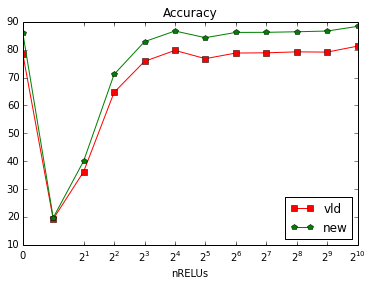

In [52]:
plt.figure()
#plt.plot(models['nRELUs'], models['accuracy_score.fit'], 'bo-', label = 'fit')
plt.plot(models['nRELUs'], models['accuracy_scoreVld'], 'rs-', label = 'vld')
plt.plot(models['nRELUs'], models['accuracy_scoreTst'], 'gp-', label = 'new')
plt.legend(loc = 'lower right')
plt.title("accuracy_score")
plt.xscale('symlog', basex=2)
axes = plt.gca()
axes.set_xlabel('nRELUs')
# axes.set_xlim([mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()] / 10 ** 2, \
#                mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()] * 10 ** 2])
# axes.set_ylim([0, mdlDF['RSS.vld'].min() * 1.5])
plt.show()